# Imports

In [59]:
import numpy as np
import pandas as pd

import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [60]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 주가 데이터

In [61]:
# 주가 URL
stock_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/B05_KM_StockPrice_for_regression.xlsx'

In [62]:
# 주가 데이터 나누기
samsung_stock = pd.read_excel(stock_url, sheet_name='005930', header=0).drop(columns='Sentiment')
lg_stock = pd.read_excel(stock_url, sheet_name='066570', header=0).drop(columns='Sentiment')
yg_stock = pd.read_excel(stock_url, sheet_name='122870', header=0).drop(columns='Sentiment')
jyp_stock = pd.read_excel(stock_url, sheet_name='035900', header=0).drop(columns='Sentiment')

# 뉴스기사 데이터

In [63]:
# 기사 URL
news_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/C06_KM_Data_all_labeled.xlsx'
news_data = pd.read_excel(news_url, sheet_name='all').drop(columns=['URL', 'Sample Y/N', 'In Charge', 'S'])

In [64]:
news_data[:3]

,No,Code,Date,Journal,Title,Text,Sentiment Dict,Polarity,Kobert,One-Hot
0,1,5930,2021.04.14 17:56,서울경제,창문형 에어컨 돌풍...삼성까지 뛰어들었다,"中 요오 일렉트릭이 만든 에어컨삼성, 내달 출시 맞춰 인증 마무리위니아딤채도 제품 ...",1,0.104940,0,0
1,2,5930,2021.04.14 17:54,이데일리,"삼성전자, 백악관 회의 언급하며 “반도체산업 발전 대화 기회 감사”","트위터 통해 바이든 대통령과 정부 관계자들에 감사마이크론·글로벌파운드리, 반도체 공...",1,0.166399,1,1
2,3,5930,2021.04.14 17:53,아시아경제,"백악관 회의 참석한 삼성전자, ""대화 자리 만든 바이든에 감사"" 트윗",삼성전자 북미총괄 대외협력 트위터 캡쳐[아시아경제 정현진 기자] 삼성전자를 비롯해 ...,1,0.295411,1,0


In [65]:
samsung_news = news_data[news_data['Code']==5930]
lg_news = news_data[news_data['Code']==66570]
yg_news = news_data[news_data['Code']==122870]
jyp_news = news_data[news_data['Code']==35900]

In [75]:
def make_dataset(data, label, window_size=20):  #> 데이터 셋 window_size 수 만큼의 일주가 데이터로 예측 하기위해 dataset 나눔.
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))   # 예측하고자 하는 날의 전날부터 20일전까지의 주가 데이터
        label_list.append(np.array(label.iloc[i+window_size]))      # 예측하고자 하는 날의 label(Close:종가) 데이터
    return np.array(feature_list), np.array(label_list)

# 삼성

## 삼성 뉴스 감성데이터

In [66]:
samsung_sentiment = samsung_news[['Date', 'Sentiment Dict', 'Polarity', 'Kobert', 'One-Hot']]

In [67]:
samsung_sentiment['Date'] = [ date.split(' ')[0] for date in samsung_sentiment['Date']] 
samsung_sentiment['Date'] = [ datetime.datetime.strptime(date, '%Y.%m.%d') for date in samsung_sentiment['Date']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
# 기사 -> 다음날에 영향을 끼친다 -> 기사 날짜 + 1일씩, 금요일은 +3일, 토요일은 +2일
days = ['월','화','수','목','금','토','일']
for i in range(len(samsung_sentiment)):
    if days[samsung_sentiment.iloc[i].Date.weekday()] == '금':
        samsung_sentiment['Date'].iloc[i] = samsung_sentiment['Date'].iloc[i] + datetime.timedelta(days=3)
    elif days[samsung_sentiment.iloc[i].Date.weekday()] == '토':
        samsung_sentiment['Date'].iloc[i] = samsung_sentiment['Date'].iloc[i] + datetime.timedelta(days=2)
    else:
        samsung_sentiment['Date'].iloc[i] = samsung_sentiment['Date'].iloc[i] + datetime.timedelta(days=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7

In [69]:
news_count = samsung_sentiment.groupby(by='Date').count()['Sentiment Dict']
news_count = pd.DataFrame(news_count)
news_count.rename(columns = {'Sentiment Dict' : 'counts'}, inplace = True)
news_count = news_count.reset_index()

In [70]:
result = samsung_sentiment.groupby(by='Date').sum()
result = pd.DataFrame(result).reset_index()

In [71]:
samsung_sentiment = pd.merge(news_count, result, how='left', left_on='Date', right_on='Date')

## 정규화

In [77]:
# 역 minmax 스케일링
# 정규화된 종가 데이터 -> 원래 종가
def reverse_min_max_scaling(org_x, x): 
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [79]:
scaler = MinMaxScaler()

scale_cols = ['Close'] # [시가, 고가, 저가, 종가, 거래량, 거래량 변화량]
scaled_data = scaler.fit_transform(samsung_stock[scale_cols])
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = scale_cols
samsung_scaled = pd.concat([samsung_stock['Date'], scaled_data, samsung_stock['Change']],axis=1)

In [80]:
samsung_scaled = pd.merge(samsung_sentiment, samsung_scaled, how='left', left_on='Date', right_on='Date')

In [82]:
# 주식시장 쉬는 날 포함되어 있음
samsung_scaled

,Date,counts,Sentiment Dict,Polarity,Kobert,One-Hot,Close,Change
0,2020-12-22,9,9,1.745549,6,6,0.793080,-0.009589
1,2020-12-23,48,38,7.624379,31,24,0.810784,0.022130
2,2020-12-24,41,38,9.551033,28,25,0.853939,0.052774
3,2020-12-25,51,44,6.116801,35,22,NaN,NaN
4,2020-12-28,32,29,5.183660,27,20,0.863897,0.011568
...,...,...,...,...,...,...,...,...
78,2021-04-09,31,23,1.908877,13,11,0.918117,-0.012987
79,2021-04-12,48,32,3.547949,10,15,0.913691,-0.004785
80,2021-04-13,40,22,2.298853,15,14,0.922543,0.009615
81,2021-04-14,41,27,2.427102,11,4,0.922543,0.000000


In [83]:
#> na 값 0 으로 변환
samsung_scaled = samsung_scaled.fillna(0)

In [85]:
# 주가 데이터 없는 날의 감성 데이터 다음날짜로 넘겨주기.
for i in range(len(samsung_scaled)):
    if samsung_scaled['Close'].iloc[i] == 0:
        if days[samsung_scaled['Date'].iloc[i].weekday()] == '금':
            samsung_scaled['Date'].iloc[i] = samsung_scaled['Date'].iloc[i] + datetime.timedelta(days=3)
        elif days[samsung_scaled['Date'].iloc[i].weekday()] == '토':
            samsung_scaled['Date'].iloc[i] = samsung_scaled['Date'].iloc[i] + datetime.timedelta(days=2)
        else:
            samsung_scaled['Date'].iloc[i] = samsung_scaled['Date'].iloc[i] + datetime.timedelta(days=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [86]:
samsung_scaled = samsung_scaled.groupby(by='Date').sum()

In [87]:
samsung_scaled['Sentiment Dict'] = samsung_scaled['Sentiment Dict'] / samsung_scaled['counts']
samsung_scaled['Polarity'] = samsung_scaled['Polarity'] / samsung_scaled['counts']
samsung_scaled['Kobert'] = samsung_scaled['Kobert'] / samsung_scaled['counts']
samsung_scaled['One-Hot'] = samsung_scaled['One-Hot'] / samsung_scaled['counts']

In [88]:
samsung_scaled = samsung_scaled.reset_index()

In [89]:
samsung_scaled

,Date,counts,Sentiment Dict,Polarity,Kobert,One-Hot,Close,Change
0,2020-12-22,9,1.000000,0.193950,0.666667,0.666667,0.793080,-0.009589
1,2020-12-23,48,0.791667,0.158841,0.645833,0.500000,0.810784,0.022130
2,2020-12-24,41,0.926829,0.232952,0.682927,0.609756,0.853939,0.052774
3,2020-12-28,83,0.879518,0.136150,0.746988,0.506024,0.863897,0.011568
4,2020-12-29,53,0.735849,0.102068,0.830189,0.547170,0.859471,-0.005083
...,...,...,...,...,...,...,...,...
74,2021-04-09,31,0.741935,0.061577,0.419355,0.354839,0.918117,-0.012987
75,2021-04-12,48,0.666667,0.073916,0.208333,0.312500,0.913691,-0.004785
76,2021-04-13,40,0.550000,0.057471,0.375000,0.350000,0.922543,0.009615
77,2021-04-14,41,0.658537,0.059198,0.268293,0.097561,0.922543,0.000000


In [90]:
len(samsung_scaled)

79

## LSTM total stock data  / feature (Close + Sentiment) / label (Close)

In [155]:
# 79일간 samsung data
TEST_SIZE = 40    # 최근 15일간의 주가를 예측하겠다
WINDOW_SIZE = 5   # 5일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = samsung_scaled[:-TEST_SIZE]     
test = samsung_scaled[-TEST_SIZE:]      # 최근 15일간의 데이터 -> test 데이터

In [156]:
feature_cols_1 = ['Close', 'Sentiment Dict']
feature_cols_2 = ['Close', 'Polarity']
feature_cols_3 = ['Close', 'Kobert']
feature_cols_4 = ['Close', 'One-Hot']
feature_cols_5 = ['Close', 'Sentiment Dict', 'Polarity']
feature_cols_6 = ['Close', 'Kobert', 'Polarity']
feature_cols_7 = ['Close', 'One-Hot', 'Polarity']
feature_cols_8 = ['Close', 'Sentiment Dict', 'Kobert', 'One-Hot', 'Polarity']

label_cols = ['Close']  # label 데이터(종가)

train_feature_1 = train[feature_cols_1]
train_feature_2 = train[feature_cols_2]
train_feature_3 = train[feature_cols_3]
train_feature_4 = train[feature_cols_4]
train_feature_5 = train[feature_cols_5]
train_feature_6 = train[feature_cols_6]
train_feature_7 = train[feature_cols_7]
train_feature_8 = train[feature_cols_8]
train_label = train[label_cols]

# train dataset 생성
train_feature_1, train_label_1 = make_dataset(train_feature_1, train_label, WINDOW_SIZE)
train_feature_2, train_label_2 = make_dataset(train_feature_2, train_label, WINDOW_SIZE)
train_feature_3, train_label_3 = make_dataset(train_feature_3, train_label, WINDOW_SIZE)
train_feature_4, train_label_4 = make_dataset(train_feature_4, train_label, WINDOW_SIZE)
train_feature_5, train_label_5 = make_dataset(train_feature_5, train_label, WINDOW_SIZE)
train_feature_6, train_label_6 = make_dataset(train_feature_6, train_label, WINDOW_SIZE)
train_feature_7, train_label_7 = make_dataset(train_feature_7, train_label, WINDOW_SIZE)
train_feature_8, train_label_8 = make_dataset(train_feature_8, train_label, WINDOW_SIZE)

# train, validation set 생성
x_train_1, x_valid_1, y_train_1, y_valid_1 = train_test_split(train_feature_1, train_label_1, test_size=0.2)
x_train_2, x_valid_2, y_train_2, y_valid_2 = train_test_split(train_feature_2, train_label_2, test_size=0.2)
x_train_3, x_valid_3, y_train_3, y_valid_3 = train_test_split(train_feature_3, train_label_3, test_size=0.2)
x_train_4, x_valid_4, y_train_4, y_valid_4 = train_test_split(train_feature_4, train_label_4, test_size=0.2)
x_train_5, x_valid_5, y_train_5, y_valid_5 = train_test_split(train_feature_5, train_label_5, test_size=0.2)
x_train_6, x_valid_6, y_train_6, y_valid_6 = train_test_split(train_feature_6, train_label_6, test_size=0.2)
x_train_7, x_valid_7, y_train_7, y_valid_7 = train_test_split(train_feature_7, train_label_7, test_size=0.2)
x_train_8, x_valid_8, y_train_8, y_valid_8 = train_test_split(train_feature_8, train_label_8, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature_1 = test[feature_cols_1]
test_feature_2 = test[feature_cols_2]
test_feature_3 = test[feature_cols_3]
test_feature_4 = test[feature_cols_4]
test_feature_5 = test[feature_cols_5]
test_feature_6 = test[feature_cols_6]
test_feature_7 = test[feature_cols_7]
test_feature_8 = test[feature_cols_8]
test_label = test[label_cols]

test_feature_1, test_label_1 = make_dataset(test_feature_1, test_label, WINDOW_SIZE)
test_feature_2, test_label_2 = make_dataset(test_feature_2, test_label, WINDOW_SIZE)
test_feature_3, test_label_3 = make_dataset(test_feature_3, test_label, WINDOW_SIZE)
test_feature_4, test_label_4 = make_dataset(test_feature_4, test_label, WINDOW_SIZE)
test_feature_5, test_label_5 = make_dataset(test_feature_5, test_label, WINDOW_SIZE)
test_feature_6, test_label_6 = make_dataset(test_feature_6, test_label, WINDOW_SIZE)
test_feature_7, test_label_7 = make_dataset(test_feature_7, test_label, WINDOW_SIZE)
test_feature_8, test_label_8 = make_dataset(test_feature_8, test_label, WINDOW_SIZE)

### 모델 1. sentiment dict

In [157]:
# 모델 생성
model_1 = Sequential()
model_1.add(LSTM(32, input_shape=(train_feature_1.shape[1], train_feature_1.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_1.add(Dropout(0.3))
model_1.add(Dense(1))
model_1.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_1 = model_1.fit(x_train_1, y_train_1, epochs=300, batch_size=16, validation_data=(x_valid_1, y_valid_1), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
2/2 [==============================] - 5s 410ms/step - loss: 0.9887 - val_loss: 0.9352
Epoch 2/300
2/2 [==============================] - 0s 88ms/step - loss: 0.8271 - val_loss: 0.8603
Epoch 3/300
2/2 [==============================] - 0s 121ms/step - loss: 0.7951 - val_loss: 0.7907
Epoch 4/300
2/2 [==============================] - 0s 87ms/step - loss: 0.7429 - val_loss: 0.7255
Epoch 5/300
2/2 [==============================] - 0s 101ms/step - loss: 0.6180 - val_loss: 0.6645
Epoch 6/300
2/2 [==============================] - 0s 100ms/step - loss: 0.6226 - val_loss: 0.6062
Epoch 7/300
2/2 [==============================] - 0s 110ms/step - loss: 0.5954 - val_loss: 0.5509
Epoch 8/300
2/2 [==============================] - 0s 81ms/step - loss: 0.5420 - val_loss: 0.4981
Epoch 9/300
2/2 [==============================] - 0s 89ms/step - loss: 0.4901 - val_loss: 0.4481
Epoch 10/300
2/2 [==============================] - 0s 72ms/step - loss: 0.4289 - val_loss: 0.4015
Epoch 11/300
2

In [158]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_1 = model_1.predict(test_feature_1)

In [159]:
model_1.evaluate(test_feature_1, test_label_1) # 0.0024

2/2 [==============================] - 0s 16ms/step - loss: 0.0050


0.005015670787543058

### 모델 2. polarity

In [160]:
# 모델 생성
model_2 = Sequential()
model_2.add(LSTM(32, input_shape=(train_feature_2.shape[1], train_feature_2.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_2.add(Dropout(0.3))
model_2.add(Dense(1))
model_2.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_2 = model_2.fit(x_train_2, y_train_2, epochs=300, batch_size=16, validation_data=(x_valid_2, y_valid_2), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
2/2 [==============================] - 4s 549ms/step - loss: 1.2015 - val_loss: 0.9531
Epoch 2/300
2/2 [==============================] - 0s 68ms/step - loss: 1.0504 - val_loss: 0.8982
Epoch 3/300
2/2 [==============================] - 0s 71ms/step - loss: 1.0120 - val_loss: 0.8478
Epoch 4/300
2/2 [==============================] - 0s 74ms/step - loss: 0.9406 - val_loss: 0.8007
Epoch 5/300
2/2 [==============================] - 0s 82ms/step - loss: 0.8996 - val_loss: 0.7557
Epoch 6/300
2/2 [==============================] - 0s 84ms/step - loss: 0.8256 - val_loss: 0.7132
Epoch 7/300
2/2 [==============================] - 0s 90ms/step - loss: 0.8007 - val_loss: 0.6726
Epoch 8/300
2/2 [==============================] - 0s 98ms/step - loss: 0.7612 - val_loss: 0.6341
Epoch 9/300
2/2 [==============================] - 0s 85ms/step - loss: 0.7204 - val_loss: 0.5971
Epoch 10/300
2/2 [==============================] - 0s 59ms/step - loss: 0.6817 - val_loss: 0.5616
Epoch 11/300
2/2 [

In [161]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_2 = model_2.predict(test_feature_2)

In [162]:
model_2.evaluate(test_feature_2, test_label_2) # / 0.0027 / 0.0030

2/2 [==============================] - 0s 9ms/step - loss: 5.8091e-04


0.0005809056456200778

### 모델 3. kobert

In [163]:
# 모델 생성
model_3 = Sequential()
model_3.add(LSTM(32, input_shape=(train_feature_3.shape[1], train_feature_3.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_3.add(Dropout(0.3))
model_3.add(Dense(1))
model_3.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_3 = model_3.fit(x_train_3, y_train_3, epochs=300, batch_size=16, validation_data=(x_valid_2, y_valid_2), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
2/2 [==============================] - 3s 431ms/step - loss: 0.8737 - val_loss: 0.6563
Epoch 2/300
2/2 [==============================] - 0s 70ms/step - loss: 0.7865 - val_loss: 0.6055
Epoch 3/300
2/2 [==============================] - 0s 95ms/step - loss: 0.7204 - val_loss: 0.5598
Epoch 4/300
2/2 [==============================] - 0s 67ms/step - loss: 0.5851 - val_loss: 0.5179
Epoch 5/300
2/2 [==============================] - 0s 87ms/step - loss: 0.5577 - val_loss: 0.4789
Epoch 6/300
2/2 [==============================] - 0s 85ms/step - loss: 0.5776 - val_loss: 0.4422
Epoch 7/300
2/2 [==============================] - 0s 73ms/step - loss: 0.4757 - val_loss: 0.4082
Epoch 8/300
2/2 [==============================] - 0s 72ms/step - loss: 0.3821 - val_loss: 0.3764
Epoch 9/300
2/2 [==============================] - 0s 64ms/step - loss: 0.4161 - val_loss: 0.3464
Epoch 10/300
2/2 [==============================] - 0s 74ms/step - loss: 0.3594 - val_loss: 0.3184
Epoch 11/300
2/2 [

In [164]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_3 = model_3.predict(test_feature_3)

In [165]:
model_3.evaluate(test_feature_3, test_label_3) # / 0.0060 / 0.01

2/2 [==============================] - 0s 7ms/step - loss: 0.0025


0.002545804250985384

### 모델 4. one-hot

In [166]:
# 모델 생성
model_4 = Sequential()
model_4.add(LSTM(32, input_shape=(train_feature_4.shape[1], train_feature_4.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_4.add(Dropout(0.3))
model_4.add(Dense(1))
model_4.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4 = model_4.fit(x_train_4, y_train_4, epochs=300, batch_size=16, validation_data=(x_valid_4, y_valid_4), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
2/2 [==============================] - 2s 350ms/step - loss: 0.7851 - val_loss: 0.7127
Epoch 2/300
2/2 [==============================] - 0s 51ms/step - loss: 0.6829 - val_loss: 0.6508
Epoch 3/300
2/2 [==============================] - 0s 50ms/step - loss: 0.6360 - val_loss: 0.5960
Epoch 4/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5689 - val_loss: 0.5460
Epoch 5/300
2/2 [==============================] - 0s 64ms/step - loss: 0.5192 - val_loss: 0.4991
Epoch 6/300
2/2 [==============================] - 0s 55ms/step - loss: 0.4625 - val_loss: 0.4551
Epoch 7/300
2/2 [==============================] - 0s 52ms/step - loss: 0.4541 - val_loss: 0.4130
Epoch 8/300
2/2 [==============================] - 0s 58ms/step - loss: 0.3892 - val_loss: 0.3729
Epoch 9/300
2/2 [==============================] - 0s 55ms/step - loss: 0.3768 - val_loss: 0.3349
Epoch 10/300
2/2 [==============================] - 0s 52ms/step - loss: 0.3420 - val_loss: 0.2990
Epoch 11/300
2/2 [

In [167]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_4 = model_4.predict(test_feature_4)

In [168]:
model_4.evaluate(test_feature_4, test_label_4) # / 0.0037 / 0.0055

2/2 [==============================] - 0s 7ms/step - loss: 0.0031


0.0030734012834727764

### 모델 5. sentiment_dict + polarity

In [169]:
# 모델 생성
model_5 = Sequential()
model_5.add(LSTM(32, input_shape=(train_feature_5.shape[1], train_feature_5.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_5.add(Dropout(0.3))
model_5.add(Dense(1))
model_5.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5 = model_5.fit(x_train_5, y_train_5, epochs=300, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
2/2 [==============================] - 4s 359ms/step - loss: 0.4615 - val_loss: 0.4512
Epoch 2/300
2/2 [==============================] - 0s 52ms/step - loss: 0.4282 - val_loss: 0.3870
Epoch 3/300
2/2 [==============================] - 0s 55ms/step - loss: 0.3952 - val_loss: 0.3292
Epoch 4/300
2/2 [==============================] - 0s 52ms/step - loss: 0.2981 - val_loss: 0.2772
Epoch 5/300
2/2 [==============================] - 0s 49ms/step - loss: 0.2617 - val_loss: 0.2316
Epoch 6/300
2/2 [==============================] - 0s 57ms/step - loss: 0.2165 - val_loss: 0.1915
Epoch 7/300
2/2 [==============================] - 0s 50ms/step - loss: 0.2385 - val_loss: 0.1558
Epoch 8/300
2/2 [==============================] - 0s 57ms/step - loss: 0.2201 - val_loss: 0.1247
Epoch 9/300
2/2 [==============================] - 0s 56ms/step - loss: 0.1443 - val_loss: 0.0980
Epoch 10/300
2/2 [==============================] - 0s 66ms/step - loss: 0.1301 - val_loss: 0.0761
Epoch 11/300
2/2 [

In [170]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_5 = model_5.predict(test_feature_5)

In [171]:
model_5.evaluate(test_feature_5, test_label_5) # / 0.0027 / 0.0031

2/2 [==============================] - 0s 9ms/step - loss: 0.0053


0.005335070192813873

### 모델 6. kobert + polarity

In [172]:
# 모델 생성
model_6 = Sequential()
model_6.add(LSTM(32, input_shape=(train_feature_6.shape[1], train_feature_6.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_6.add(Dropout(0.3))
model_6.add(Dense(1))
model_6.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_6 = model_6.fit(x_train_6, y_train_6, epochs=300, batch_size=16, validation_data=(x_valid_6, y_valid_6), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
2/2 [==============================] - 3s 360ms/step - loss: 1.1847 - val_loss: 1.1980
Epoch 2/300
2/2 [==============================] - 0s 57ms/step - loss: 1.0989 - val_loss: 1.1004
Epoch 3/300
2/2 [==============================] - 0s 52ms/step - loss: 1.0261 - val_loss: 1.0131
Epoch 4/300
2/2 [==============================] - 0s 53ms/step - loss: 0.9047 - val_loss: 0.9332
Epoch 5/300
2/2 [==============================] - 0s 56ms/step - loss: 0.8655 - val_loss: 0.8603
Epoch 6/300
2/2 [==============================] - 0s 53ms/step - loss: 0.7940 - val_loss: 0.7929
Epoch 7/300
2/2 [==============================] - 0s 53ms/step - loss: 0.7436 - val_loss: 0.7305
Epoch 8/300
2/2 [==============================] - 0s 48ms/step - loss: 0.6456 - val_loss: 0.6723
Epoch 9/300
2/2 [==============================] - 0s 55ms/step - loss: 0.6600 - val_loss: 0.6177
Epoch 10/300
2/2 [==============================] - 0s 49ms/step - loss: 0.6155 - val_loss: 0.5670
Epoch 11/300
2/2 [

In [173]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_6 = model_6.predict(test_feature_6)

In [174]:
model_6.evaluate(test_feature_6, test_label_6) # / 0.0059 / 0.0082

2/2 [==============================] - 0s 10ms/step - loss: 0.0104


0.01036981400102377

### 모델 7. one-hot + polarity

In [175]:
# 모델 생성
model_7 = Sequential()
model_7.add(LSTM(32, input_shape=(train_feature_7.shape[1], train_feature_7.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_7.add(Dropout(0.3))
model_7.add(Dense(1))
model_7.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_7 = model_7.fit(x_train_7, y_train_7, epochs=300, batch_size=16, validation_data=(x_valid_7, y_valid_7), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
2/2 [==============================] - 3s 347ms/step - loss: 0.9804 - val_loss: 1.0377
Epoch 2/300
2/2 [==============================] - 0s 61ms/step - loss: 0.9821 - val_loss: 0.9517
Epoch 3/300
2/2 [==============================] - 0s 56ms/step - loss: 0.8701 - val_loss: 0.8739
Epoch 4/300
2/2 [==============================] - 0s 56ms/step - loss: 0.7812 - val_loss: 0.8019
Epoch 5/300
2/2 [==============================] - 0s 56ms/step - loss: 0.7533 - val_loss: 0.7351
Epoch 6/300
2/2 [==============================] - 0s 54ms/step - loss: 0.7085 - val_loss: 0.6729
Epoch 7/300
2/2 [==============================] - 0s 67ms/step - loss: 0.6019 - val_loss: 0.6148
Epoch 8/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5559 - val_loss: 0.5610
Epoch 9/300
2/2 [==============================] - 0s 54ms/step - loss: 0.5457 - val_loss: 0.5102
Epoch 10/300
2/2 [==============================] - 0s 54ms/step - loss: 0.4767 - val_loss: 0.4626
Epoch 11/300
2/2 [

In [176]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_7 = model_7.predict(test_feature_7)

In [177]:
model_7.evaluate(test_feature_7, test_label_7) # / 0.0039 / 0.0076

2/2 [==============================] - 0s 6ms/step - loss: 0.0030


0.0030029991175979376

### 모델 8. 'Sentiment Dict', 'Kobert', 'One-Hot', 'Polarity'

In [178]:
# 모델 생성
model_8 = Sequential()
model_8.add(LSTM(32, input_shape=(train_feature_8.shape[1], train_feature_8.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_8.add(Dropout(0.3))
model_8.add(Dense(1))
model_8.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_8 = model_8.fit(x_train_8, y_train_8, epochs=300, batch_size=16, validation_data=(x_valid_8, y_valid_8), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
2/2 [==============================] - 3s 374ms/step - loss: 0.9405 - val_loss: 0.7667
Epoch 2/300
2/2 [==============================] - 0s 61ms/step - loss: 0.8701 - val_loss: 0.6747
Epoch 3/300
2/2 [==============================] - 0s 62ms/step - loss: 0.6631 - val_loss: 0.5942
Epoch 4/300
2/2 [==============================] - 0s 60ms/step - loss: 0.5866 - val_loss: 0.5227
Epoch 5/300
2/2 [==============================] - 0s 58ms/step - loss: 0.5522 - val_loss: 0.4581
Epoch 6/300
2/2 [==============================] - 0s 56ms/step - loss: 0.5058 - val_loss: 0.4004
Epoch 7/300
2/2 [==============================] - 0s 55ms/step - loss: 0.4287 - val_loss: 0.3491
Epoch 8/300
2/2 [==============================] - 0s 66ms/step - loss: 0.3679 - val_loss: 0.3033
Epoch 9/300
2/2 [==============================] - 0s 57ms/step - loss: 0.3226 - val_loss: 0.2634
Epoch 10/300
2/2 [==============================] - 0s 60ms/step - loss: 0.2552 - val_loss: 0.2290
Epoch 11/300
2/2 [

In [179]:
predicted_stock_8 = model_8.predict(test_feature_8)
model_8.evaluate(test_feature_8, test_label_8) # 0.0042

2/2 [==============================] - 0s 8ms/step - loss: 0.0016


0.001585179939866066

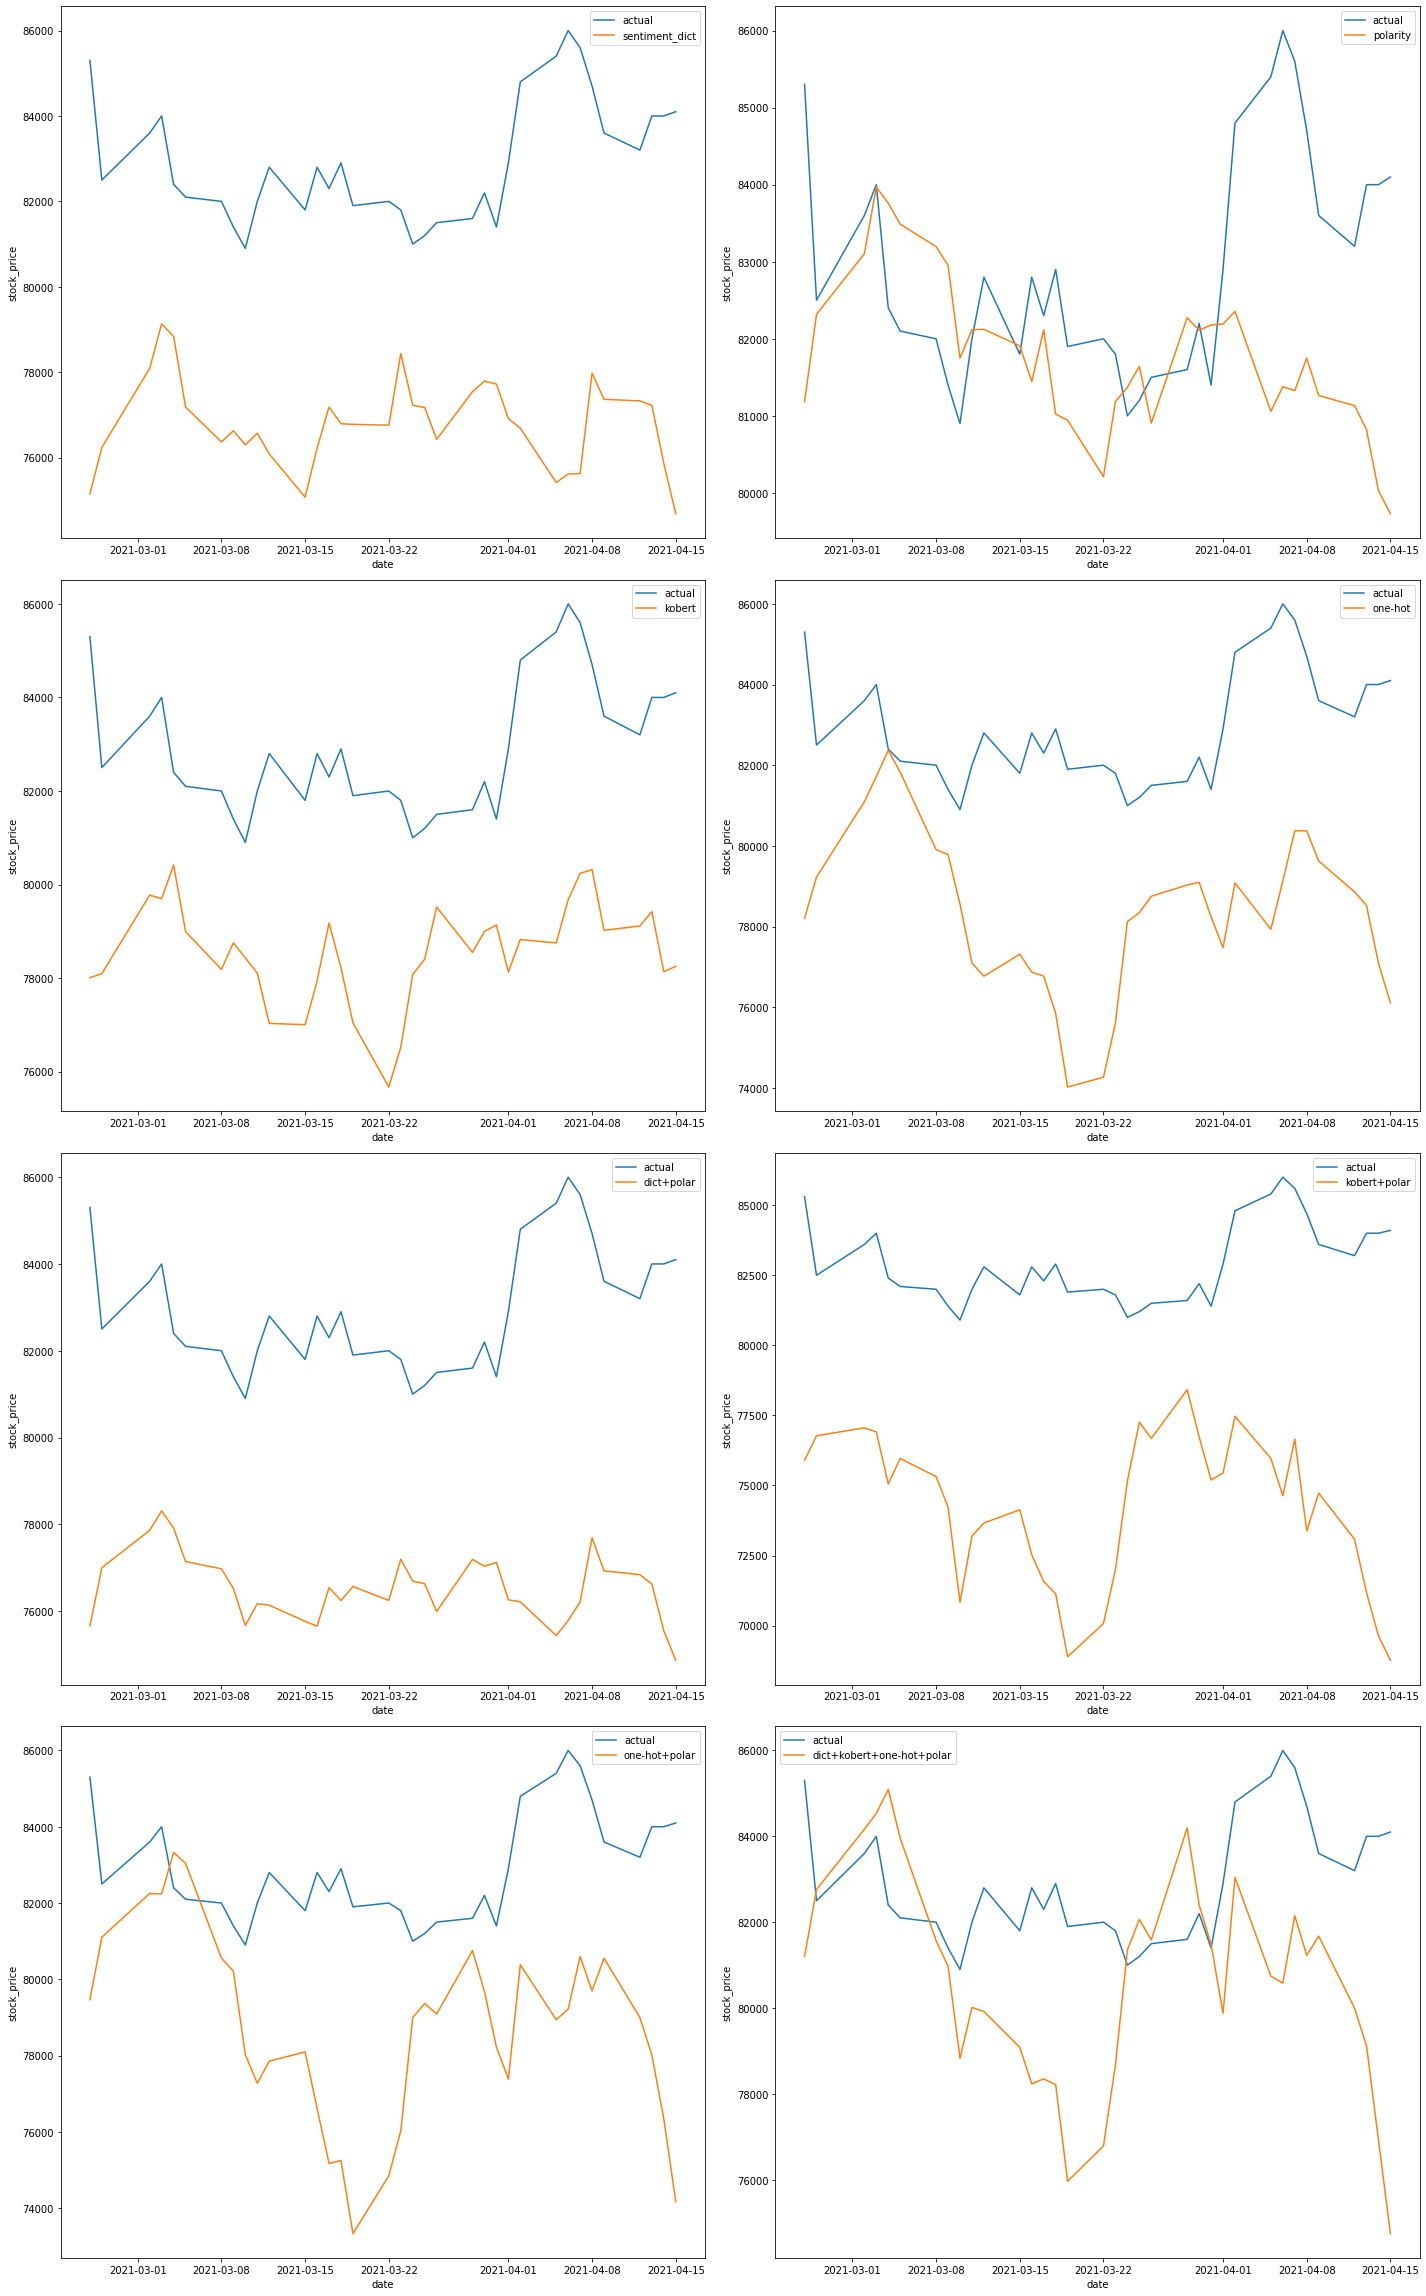

In [189]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]

plt.figure(figsize=(20, 32))
plt.title('Samsung stock prediction')

ax1 = plt.subplot(4,2,1)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_1), label = 'sentiment_dict')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax2 = plt.subplot(4,2,2)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_2), label = 'polarity')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax3 = plt.subplot(4,2,3)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_3), label = 'kobert')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax4 = plt.subplot(4,2,4)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4), label = 'one-hot')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax5 = plt.subplot(4,2,5)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5), label = 'dict+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax6 = plt.subplot(4,2,6)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_6), label = 'kobert+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax7 = plt.subplot(4,2,7)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_7), label = 'one-hot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax8 = plt.subplot(4,2,8)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_8), label = 'dict+kobert+one-hot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()



plt.tight_layout()
plt.show()

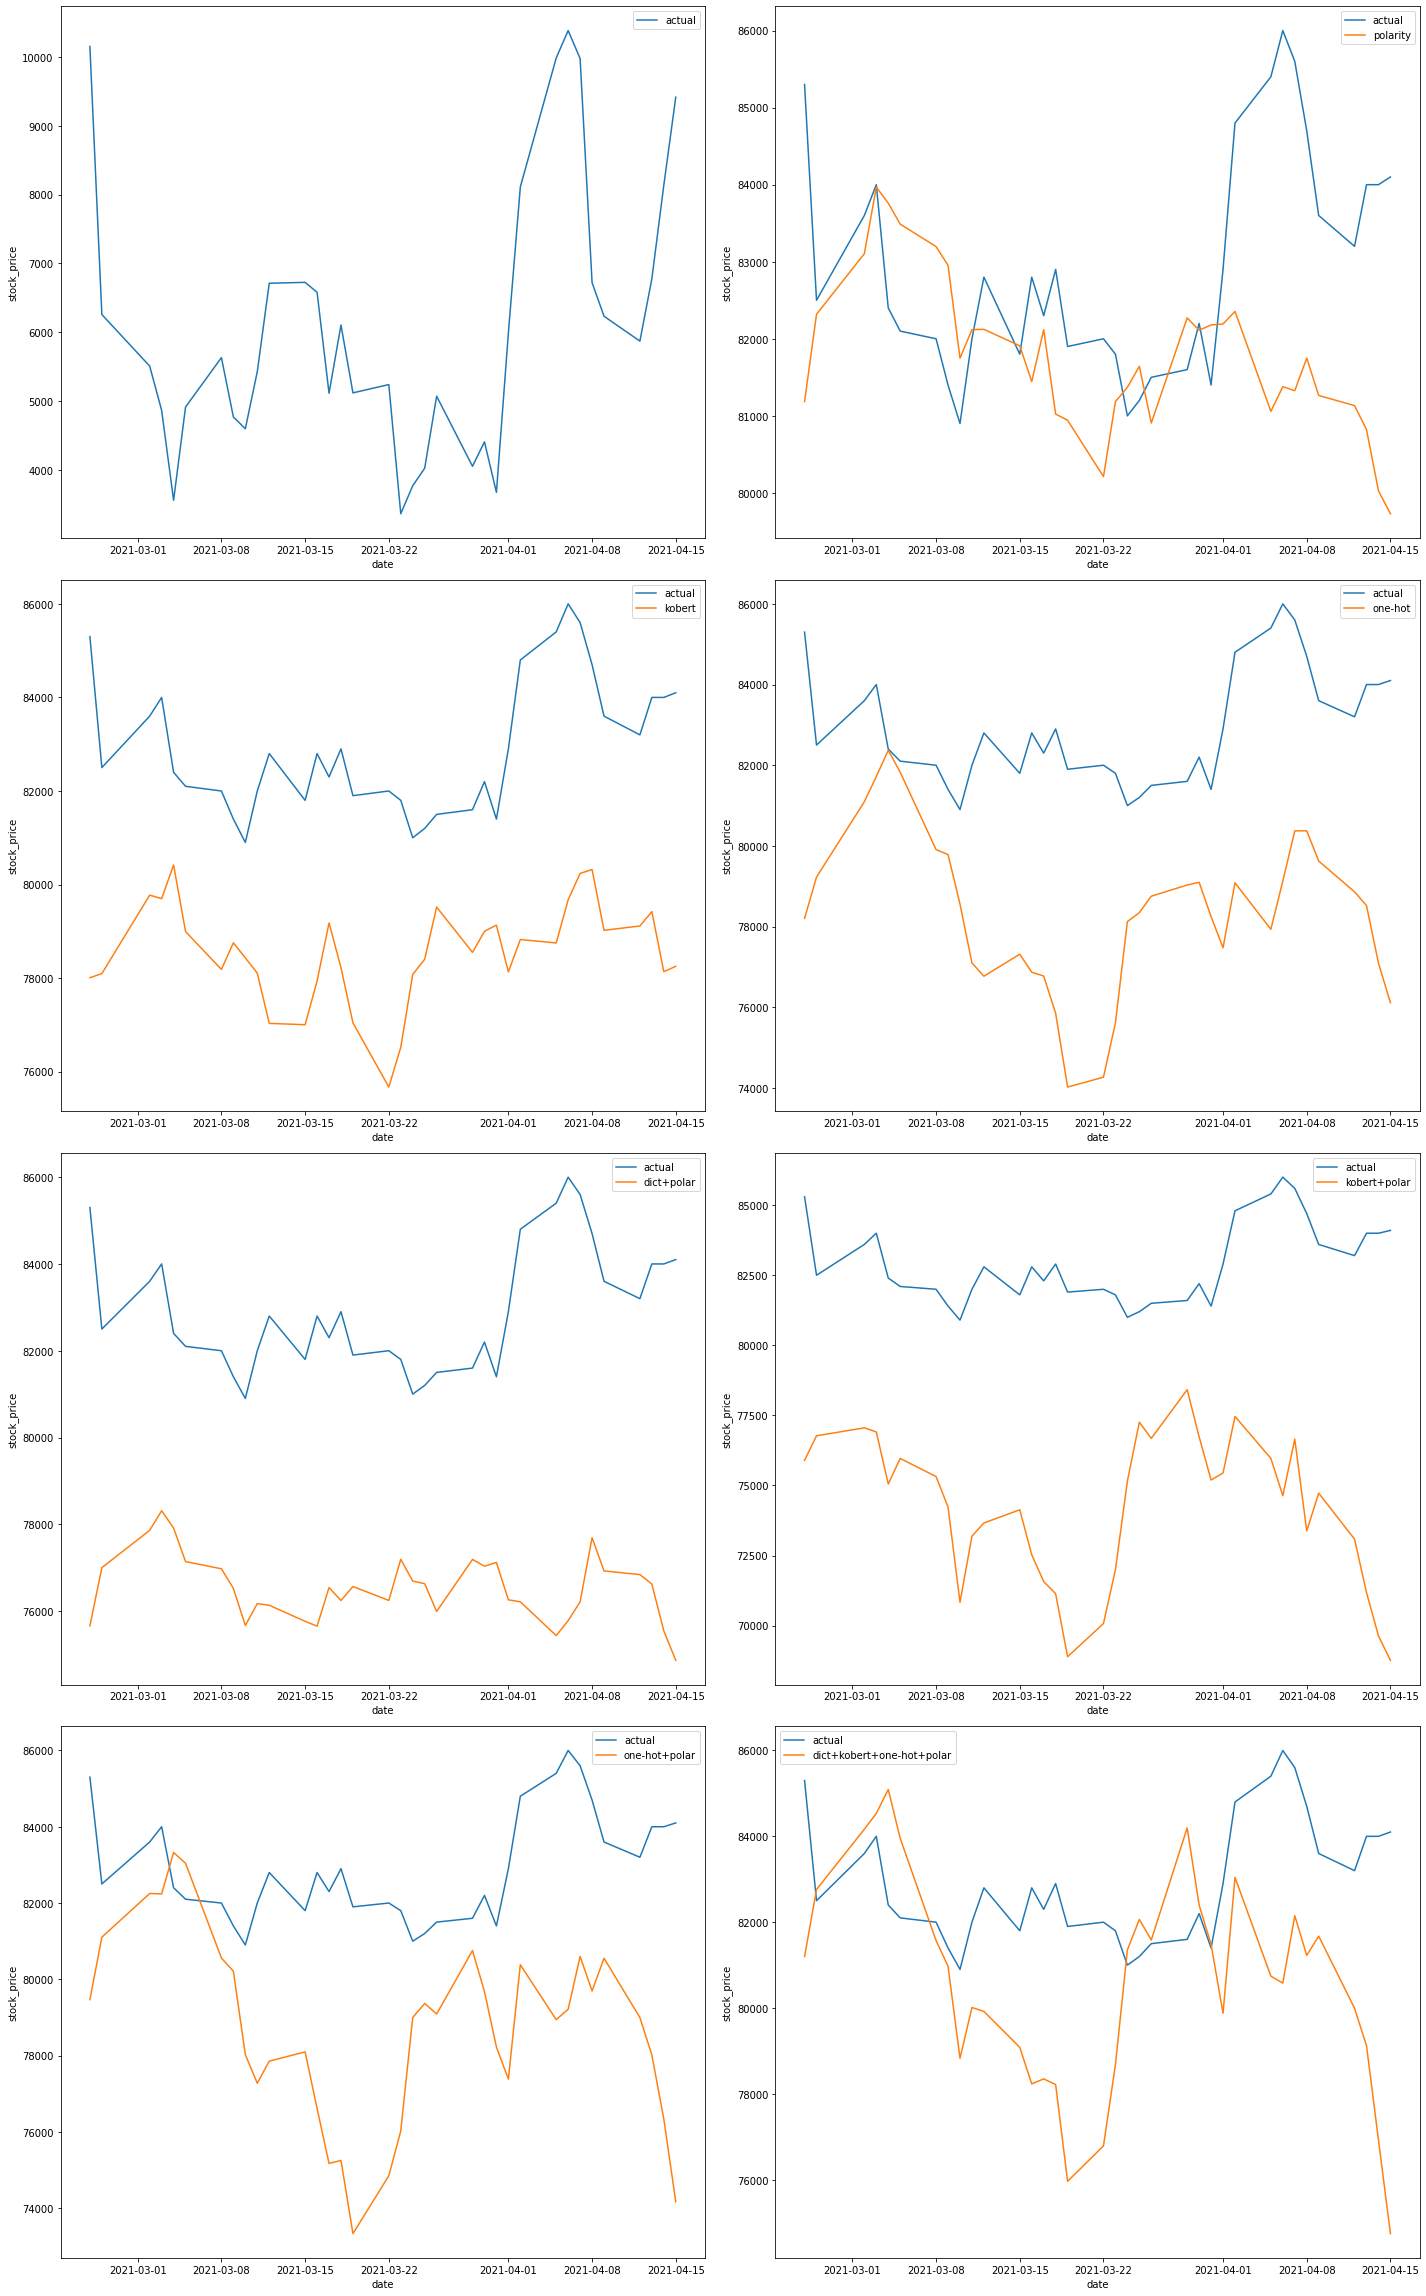

In [190]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]

plt.figure(figsize=(20, 32))
plt.title('Samsung stock prediction')

ax1 = plt.subplot(4,2,1)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1) - reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_1), label = 'actual')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax2 = plt.subplot(4,2,2)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_2), label = 'polarity')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax3 = plt.subplot(4,2,3)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_3), label = 'kobert')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax4 = plt.subplot(4,2,4)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4), label = 'one-hot')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax5 = plt.subplot(4,2,5)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5), label = 'dict+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax6 = plt.subplot(4,2,6)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_6), label = 'kobert+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax7 = plt.subplot(4,2,7)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_7), label = 'one-hot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax8 = plt.subplot(4,2,8)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_8), label = 'dict+kobert+one-hot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()



plt.tight_layout()
plt.show()

## LSTM total stock data  / feature (Change + Sentiment) / label (Close)

In [245]:
# 79일간 samsung data
TEST_SIZE = 27    # 최근 15일간의 주가를 예측하겠다
WINDOW_SIZE = 3   # 5일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = samsung_scaled[:-TEST_SIZE]     
test = samsung_scaled[-TEST_SIZE:]      # 최근 15일간의 데이터 -> test 데이터

In [246]:
feature_cols_1 = ['Change', 'Sentiment Dict']
feature_cols_2 = ['Change', 'Polarity']
feature_cols_3 = ['Change', 'Kobert']
feature_cols_4 = ['Change', 'One-Hot']
feature_cols_5 = ['Change', 'Sentiment Dict', 'Polarity']
feature_cols_6 = ['Change', 'Kobert', 'Polarity']
feature_cols_7 = ['Change', 'One-Hot', 'Polarity']
feature_cols_8 = ['Change', 'Sentiment Dict', 'Kobert', 'One-Hot', 'Polarity']

label_cols = ['Close']  # label 데이터(종가)

train_feature_1 = train[feature_cols_1]
train_feature_2 = train[feature_cols_2]
train_feature_3 = train[feature_cols_3]
train_feature_4 = train[feature_cols_4]
train_feature_5 = train[feature_cols_5]
train_feature_6 = train[feature_cols_6]
train_feature_7 = train[feature_cols_7]
train_feature_8 = train[feature_cols_8]

train_label = train[label_cols]

# train dataset 생성
train_feature_1, train_label_1 = make_dataset(train_feature_1, train_label, WINDOW_SIZE)
train_feature_2, train_label_2 = make_dataset(train_feature_2, train_label, WINDOW_SIZE)
train_feature_3, train_label_3 = make_dataset(train_feature_3, train_label, WINDOW_SIZE)
train_feature_4, train_label_4 = make_dataset(train_feature_4, train_label, WINDOW_SIZE)
train_feature_5, train_label_5 = make_dataset(train_feature_5, train_label, WINDOW_SIZE)
train_feature_6, train_label_6 = make_dataset(train_feature_6, train_label, WINDOW_SIZE)
train_feature_7, train_label_7 = make_dataset(train_feature_7, train_label, WINDOW_SIZE)
train_feature_8, train_label_8 = make_dataset(train_feature_8, train_label, WINDOW_SIZE)


# train, validation set 생성
x_train_1, x_valid_1, y_train_1, y_valid_1 = train_test_split(train_feature_1, train_label_1, test_size=0.2)
x_train_2, x_valid_2, y_train_2, y_valid_2 = train_test_split(train_feature_2, train_label_2, test_size=0.2)
x_train_3, x_valid_3, y_train_3, y_valid_3 = train_test_split(train_feature_3, train_label_3, test_size=0.2)
x_train_4, x_valid_4, y_train_4, y_valid_4 = train_test_split(train_feature_4, train_label_4, test_size=0.2)
x_train_5, x_valid_5, y_train_5, y_valid_5 = train_test_split(train_feature_5, train_label_5, test_size=0.2)
x_train_6, x_valid_6, y_train_6, y_valid_6 = train_test_split(train_feature_6, train_label_6, test_size=0.2)
x_train_7, x_valid_7, y_train_7, y_valid_7 = train_test_split(train_feature_7, train_label_7, test_size=0.2)
x_train_8, x_valid_8, y_train_8, y_valid_8 = train_test_split(train_feature_8, train_label_8, test_size=0.2)


# test dataset (실제 예측 해볼 데이터)
test_feature_1 = test[feature_cols_1]
test_feature_2 = test[feature_cols_2]
test_feature_3 = test[feature_cols_3]
test_feature_4 = test[feature_cols_4]
test_feature_5 = test[feature_cols_5]
test_feature_6 = test[feature_cols_6]
test_feature_7 = test[feature_cols_7]
test_feature_8 = test[feature_cols_8]
test_label = test[label_cols]

test_feature_1, test_label_1 = make_dataset(test_feature_1, test_label, WINDOW_SIZE)
test_feature_2, test_label_2 = make_dataset(test_feature_2, test_label, WINDOW_SIZE)
test_feature_3, test_label_3 = make_dataset(test_feature_3, test_label, WINDOW_SIZE)
test_feature_4, test_label_4 = make_dataset(test_feature_4, test_label, WINDOW_SIZE)
test_feature_5, test_label_5 = make_dataset(test_feature_5, test_label, WINDOW_SIZE)
test_feature_6, test_label_6 = make_dataset(test_feature_6, test_label, WINDOW_SIZE)
test_feature_7, test_label_7 = make_dataset(test_feature_7, test_label, WINDOW_SIZE)
test_feature_8, test_label_8 = make_dataset(test_feature_8, test_label, WINDOW_SIZE)

### 모델 1. sentiment dict

In [316]:
# 모델 생성
model_1 = Sequential()
model_1.add(LSTM(32, input_shape=(train_feature_1.shape[1], train_feature_1.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_1.add(Dropout(0.3))
model_1.add(Dense(1))
model_1.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_1 = model_1.fit(x_train_1, y_train_1, epochs=300, batch_size=16, validation_data=(x_valid_1, y_valid_1), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 2s 152ms/step - loss: 0.0128 - val_loss: 0.0025
Epoch 2/300
3/3 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 7.8124e-04
Epoch 3/300
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - val_loss: 3.8442e-04
Epoch 4/300
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - val_loss: 4.3189e-04
Epoch 5/300
3/3 [==============================] - 0s 23ms/step - loss: 0.0019 - val_loss: 5.5636e-04
Epoch 6/300
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - val_loss: 6.3579e-04
Epoch 7/300
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - val_loss: 6.7215e-04
Epoch 8/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0025 - val_loss: 5.8881e-04
Epoch 9/300
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - val_loss: 4.6336e-04
Epoch 10/300
3/3 [==============================] - 0s 23ms/step - loss: 0.0024 - val

In [317]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_1 = model_1.predict(test_feature_1)

In [249]:
model_1.evaluate(test_feature_1, test_label_1) # 0.0024

1/1 [==============================] - 0s 18ms/step - loss: 0.0063


0.006312560755759478

### 모델 2. polarity

In [250]:
# 모델 생성
model_2 = Sequential()
model_2.add(LSTM(32, input_shape=(train_feature_2.shape[1], train_feature_2.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_2.add(Dropout(0.3))
model_2.add(Dense(1))
model_2.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_2 = model_2.fit(x_train_2, y_train_2, epochs=300, batch_size=16, validation_data=(x_valid_2, y_valid_2), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 2s 153ms/step - loss: 0.8223 - val_loss: 0.8501
Epoch 2/300
3/3 [==============================] - 0s 28ms/step - loss: 0.8141 - val_loss: 0.8259
Epoch 3/300
3/3 [==============================] - 0s 27ms/step - loss: 0.7616 - val_loss: 0.8029
Epoch 4/300
3/3 [==============================] - 0s 27ms/step - loss: 0.7376 - val_loss: 0.7804
Epoch 5/300
3/3 [==============================] - 0s 30ms/step - loss: 0.7337 - val_loss: 0.7579
Epoch 6/300
3/3 [==============================] - 0s 27ms/step - loss: 0.6932 - val_loss: 0.7360
Epoch 7/300
3/3 [==============================] - 0s 27ms/step - loss: 0.6902 - val_loss: 0.7139
Epoch 8/300
3/3 [==============================] - 0s 26ms/step - loss: 0.6876 - val_loss: 0.6915
Epoch 9/300
3/3 [==============================] - 0s 26ms/step - loss: 0.6519 - val_loss: 0.6690
Epoch 10/300
3/3 [==============================] - 0s 27ms/step - loss: 0.6366 - val_loss: 0.6464
Epoch 11/300
3/3 [

In [251]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_2 = model_2.predict(test_feature_2)

In [252]:
model_2.evaluate(test_feature_2, test_label_2) # / 0.0027 / 0.0030

1/1 [==============================] - 0s 17ms/step - loss: 0.0045


0.004545222502201796

### 모델 3. kobert

In [253]:
# 모델 생성
model_3 = Sequential()
model_3.add(LSTM(32, input_shape=(train_feature_3.shape[1], train_feature_3.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_3.add(Dropout(0.3))
model_3.add(Dense(1))
model_3.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_3 = model_3.fit(x_train_3, y_train_3, epochs=300, batch_size=16, validation_data=(x_valid_2, y_valid_2), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 4s 213ms/step - loss: 0.9141 - val_loss: 0.8577
Epoch 2/300
3/3 [==============================] - 0s 35ms/step - loss: 0.8610 - val_loss: 0.8356
Epoch 3/300
3/3 [==============================] - 0s 30ms/step - loss: 0.8484 - val_loss: 0.8147
Epoch 4/300
3/3 [==============================] - 0s 34ms/step - loss: 0.7800 - val_loss: 0.7947
Epoch 5/300
3/3 [==============================] - 0s 37ms/step - loss: 0.7684 - val_loss: 0.7755
Epoch 6/300
3/3 [==============================] - 0s 34ms/step - loss: 0.7578 - val_loss: 0.7572
Epoch 7/300
3/3 [==============================] - 0s 28ms/step - loss: 0.7213 - val_loss: 0.7396
Epoch 8/300
3/3 [==============================] - 0s 32ms/step - loss: 0.7040 - val_loss: 0.7224
Epoch 9/300
3/3 [==============================] - 0s 29ms/step - loss: 0.6601 - val_loss: 0.7055
Epoch 10/300
3/3 [==============================] - 0s 26ms/step - loss: 0.6370 - val_loss: 0.6889
Epoch 11/300
3/3 [

In [254]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_3 = model_3.predict(test_feature_3)

In [255]:
model_3.evaluate(test_feature_3, test_label_3) # / 0.0060 / 0.01

1/1 [==============================] - 0s 23ms/step - loss: 0.0083


0.008338062092661858

### 모델 4. one-hot

In [256]:
# 모델 생성
model_4 = Sequential()
model_4.add(LSTM(32, input_shape=(train_feature_4.shape[1], train_feature_4.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_4.add(Dropout(0.3))
model_4.add(Dense(1))
model_4.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4 = model_4.fit(x_train_4, y_train_4, epochs=300, batch_size=16, validation_data=(x_valid_4, y_valid_4), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 3s 214ms/step - loss: 0.6482 - val_loss: 0.6573
Epoch 2/300
3/3 [==============================] - 0s 37ms/step - loss: 0.6341 - val_loss: 0.6119
Epoch 3/300
3/3 [==============================] - 0s 38ms/step - loss: 0.5434 - val_loss: 0.5699
Epoch 4/300
3/3 [==============================] - 0s 37ms/step - loss: 0.5156 - val_loss: 0.5298
Epoch 5/300
3/3 [==============================] - 0s 33ms/step - loss: 0.4905 - val_loss: 0.4915
Epoch 6/300
3/3 [==============================] - 0s 38ms/step - loss: 0.4365 - val_loss: 0.4551
Epoch 7/300
3/3 [==============================] - 0s 38ms/step - loss: 0.3946 - val_loss: 0.4198
Epoch 8/300
3/3 [==============================] - 0s 33ms/step - loss: 0.3896 - val_loss: 0.3858
Epoch 9/300
3/3 [==============================] - 0s 38ms/step - loss: 0.3452 - val_loss: 0.3533
Epoch 10/300
3/3 [==============================] - 0s 34ms/step - loss: 0.3137 - val_loss: 0.3223
Epoch 11/300
3/3 [

In [257]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_4 = model_4.predict(test_feature_4)

In [258]:
model_4.evaluate(test_feature_4, test_label_4) # / 0.0037 / 0.0055

1/1 [==============================] - 0s 20ms/step - loss: 0.0074


0.007351566106081009

### 모델 5. sentiment_dict + polarity

In [259]:
# 모델 생성
model_5 = Sequential()
model_5.add(LSTM(32, input_shape=(train_feature_5.shape[1], train_feature_5.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_5.add(Dropout(0.3))
model_5.add(Dense(1))
model_5.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5 = model_5.fit(x_train_5, y_train_5, epochs=300, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 3s 196ms/step - loss: 0.6968 - val_loss: 0.6949
Epoch 2/300
3/3 [==============================] - 0s 39ms/step - loss: 0.6386 - val_loss: 0.6454
Epoch 3/300
3/3 [==============================] - 0s 33ms/step - loss: 0.5704 - val_loss: 0.5991
Epoch 4/300
3/3 [==============================] - 0s 39ms/step - loss: 0.5593 - val_loss: 0.5555
Epoch 5/300
3/3 [==============================] - 0s 46ms/step - loss: 0.5104 - val_loss: 0.5146
Epoch 6/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4744 - val_loss: 0.4756
Epoch 7/300
3/3 [==============================] - 0s 35ms/step - loss: 0.4554 - val_loss: 0.4382
Epoch 8/300
3/3 [==============================] - 0s 33ms/step - loss: 0.3937 - val_loss: 0.4028
Epoch 9/300
3/3 [==============================] - 0s 32ms/step - loss: 0.3746 - val_loss: 0.3689
Epoch 10/300
3/3 [==============================] - 0s 35ms/step - loss: 0.3500 - val_loss: 0.3361
Epoch 11/300
3/3 [

In [260]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_5 = model_5.predict(test_feature_5)

In [261]:
model_5.evaluate(test_feature_5, test_label_5) # / 0.0027 / 0.0031

1/1 [==============================] - 0s 18ms/step - loss: 0.0051


0.005108552053570747

### 모델 6. kobert + polarity

In [262]:
# 모델 생성
model_6 = Sequential()
model_6.add(LSTM(32, input_shape=(train_feature_6.shape[1], train_feature_6.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_6.add(Dropout(0.3))
model_6.add(Dense(1))
model_6.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_6 = model_6.fit(x_train_6, y_train_6, epochs=300, batch_size=16, validation_data=(x_valid_6, y_valid_6), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 3s 152ms/step - loss: 0.9132 - val_loss: 0.9179
Epoch 2/300
3/3 [==============================] - 0s 27ms/step - loss: 0.8827 - val_loss: 0.8753
Epoch 3/300
3/3 [==============================] - 0s 27ms/step - loss: 0.8000 - val_loss: 0.8365
Epoch 4/300
3/3 [==============================] - 0s 26ms/step - loss: 0.7975 - val_loss: 0.7997
Epoch 5/300
3/3 [==============================] - 0s 29ms/step - loss: 0.7558 - val_loss: 0.7648
Epoch 6/300
3/3 [==============================] - 0s 28ms/step - loss: 0.6984 - val_loss: 0.7311
Epoch 7/300
3/3 [==============================] - 0s 28ms/step - loss: 0.6729 - val_loss: 0.6986
Epoch 8/300
3/3 [==============================] - 0s 25ms/step - loss: 0.6412 - val_loss: 0.6670
Epoch 9/300
3/3 [==============================] - 0s 30ms/step - loss: 0.6168 - val_loss: 0.6362
Epoch 10/300
3/3 [==============================] - 0s 34ms/step - loss: 0.5848 - val_loss: 0.6058
Epoch 11/300
3/3 [

In [263]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_6 = model_6.predict(test_feature_6)

In [264]:
model_6.evaluate(test_feature_6, test_label_6) # / 0.0059 / 0.0082

1/1 [==============================] - 0s 30ms/step - loss: 0.0108


0.010770508088171482

### 모델 7. one-hot + polarity

In [265]:
# 모델 생성
model_7 = Sequential()
model_7.add(LSTM(32, input_shape=(train_feature_7.shape[1], train_feature_7.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_7.add(Dropout(0.3))
model_7.add(Dense(1))
model_7.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_7 = model_7.fit(x_train_7, y_train_7, epochs=300, batch_size=16, validation_data=(x_valid_7, y_valid_7), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 3s 216ms/step - loss: 0.9370 - val_loss: 0.9222
Epoch 2/300
3/3 [==============================] - 0s 32ms/step - loss: 0.9033 - val_loss: 0.8785
Epoch 3/300
3/3 [==============================] - 0s 35ms/step - loss: 0.8685 - val_loss: 0.8381
Epoch 4/300
3/3 [==============================] - 0s 33ms/step - loss: 0.8356 - val_loss: 0.8007
Epoch 5/300
3/3 [==============================] - 0s 30ms/step - loss: 0.7734 - val_loss: 0.7651
Epoch 6/300
3/3 [==============================] - 0s 32ms/step - loss: 0.7437 - val_loss: 0.7310
Epoch 7/300
3/3 [==============================] - 0s 29ms/step - loss: 0.7119 - val_loss: 0.6977
Epoch 8/300
3/3 [==============================] - 0s 29ms/step - loss: 0.7076 - val_loss: 0.6655
Epoch 9/300
3/3 [==============================] - 0s 29ms/step - loss: 0.6423 - val_loss: 0.6344
Epoch 10/300
3/3 [==============================] - 0s 28ms/step - loss: 0.6150 - val_loss: 0.6039
Epoch 11/300
3/3 [

In [266]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_7 = model_7.predict(test_feature_7)

In [267]:
model_7.evaluate(test_feature_7, test_label_7) # / 0.0039 / 0.0076

1/1 [==============================] - 0s 19ms/step - loss: 0.0058


0.005825065076351166

### 모델 8. 'Sentiment Dict', 'Kobert', 'One-Hot', 'Polarity'

In [268]:
# 모델 생성
model_8 = Sequential()
model_8.add(LSTM(32, input_shape=(train_feature_8.shape[1], train_feature_8.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_8.add(Dropout(0.3))
model_8.add(Dense(1))
model_8.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_8 = model_8.fit(x_train_8, y_train_8, epochs=300, batch_size=16, validation_data=(x_valid_8, y_valid_8), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 4s 215ms/step - loss: 0.8278 - val_loss: 0.6779
Epoch 2/300
3/3 [==============================] - 0s 31ms/step - loss: 0.7474 - val_loss: 0.6192
Epoch 3/300
3/3 [==============================] - 0s 36ms/step - loss: 0.7033 - val_loss: 0.5658
Epoch 4/300
3/3 [==============================] - 0s 33ms/step - loss: 0.6300 - val_loss: 0.5158
Epoch 5/300
3/3 [==============================] - 0s 34ms/step - loss: 0.5645 - val_loss: 0.4696
Epoch 6/300
3/3 [==============================] - 0s 37ms/step - loss: 0.5226 - val_loss: 0.4255
Epoch 7/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4529 - val_loss: 0.3841
Epoch 8/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4107 - val_loss: 0.3451
Epoch 9/300
3/3 [==============================] - 0s 38ms/step - loss: 0.3748 - val_loss: 0.3086
Epoch 10/300
3/3 [==============================] - 0s 44ms/step - loss: 0.3483 - val_loss: 0.2745
Epoch 11/300
3/3 [

In [269]:
predicted_stock_8 = model_8.predict(test_feature_8)
model_8.evaluate(test_feature_8, test_label_8) # 0.0050

1/1 [==============================] - 0s 17ms/step - loss: 0.0135


0.01350858062505722

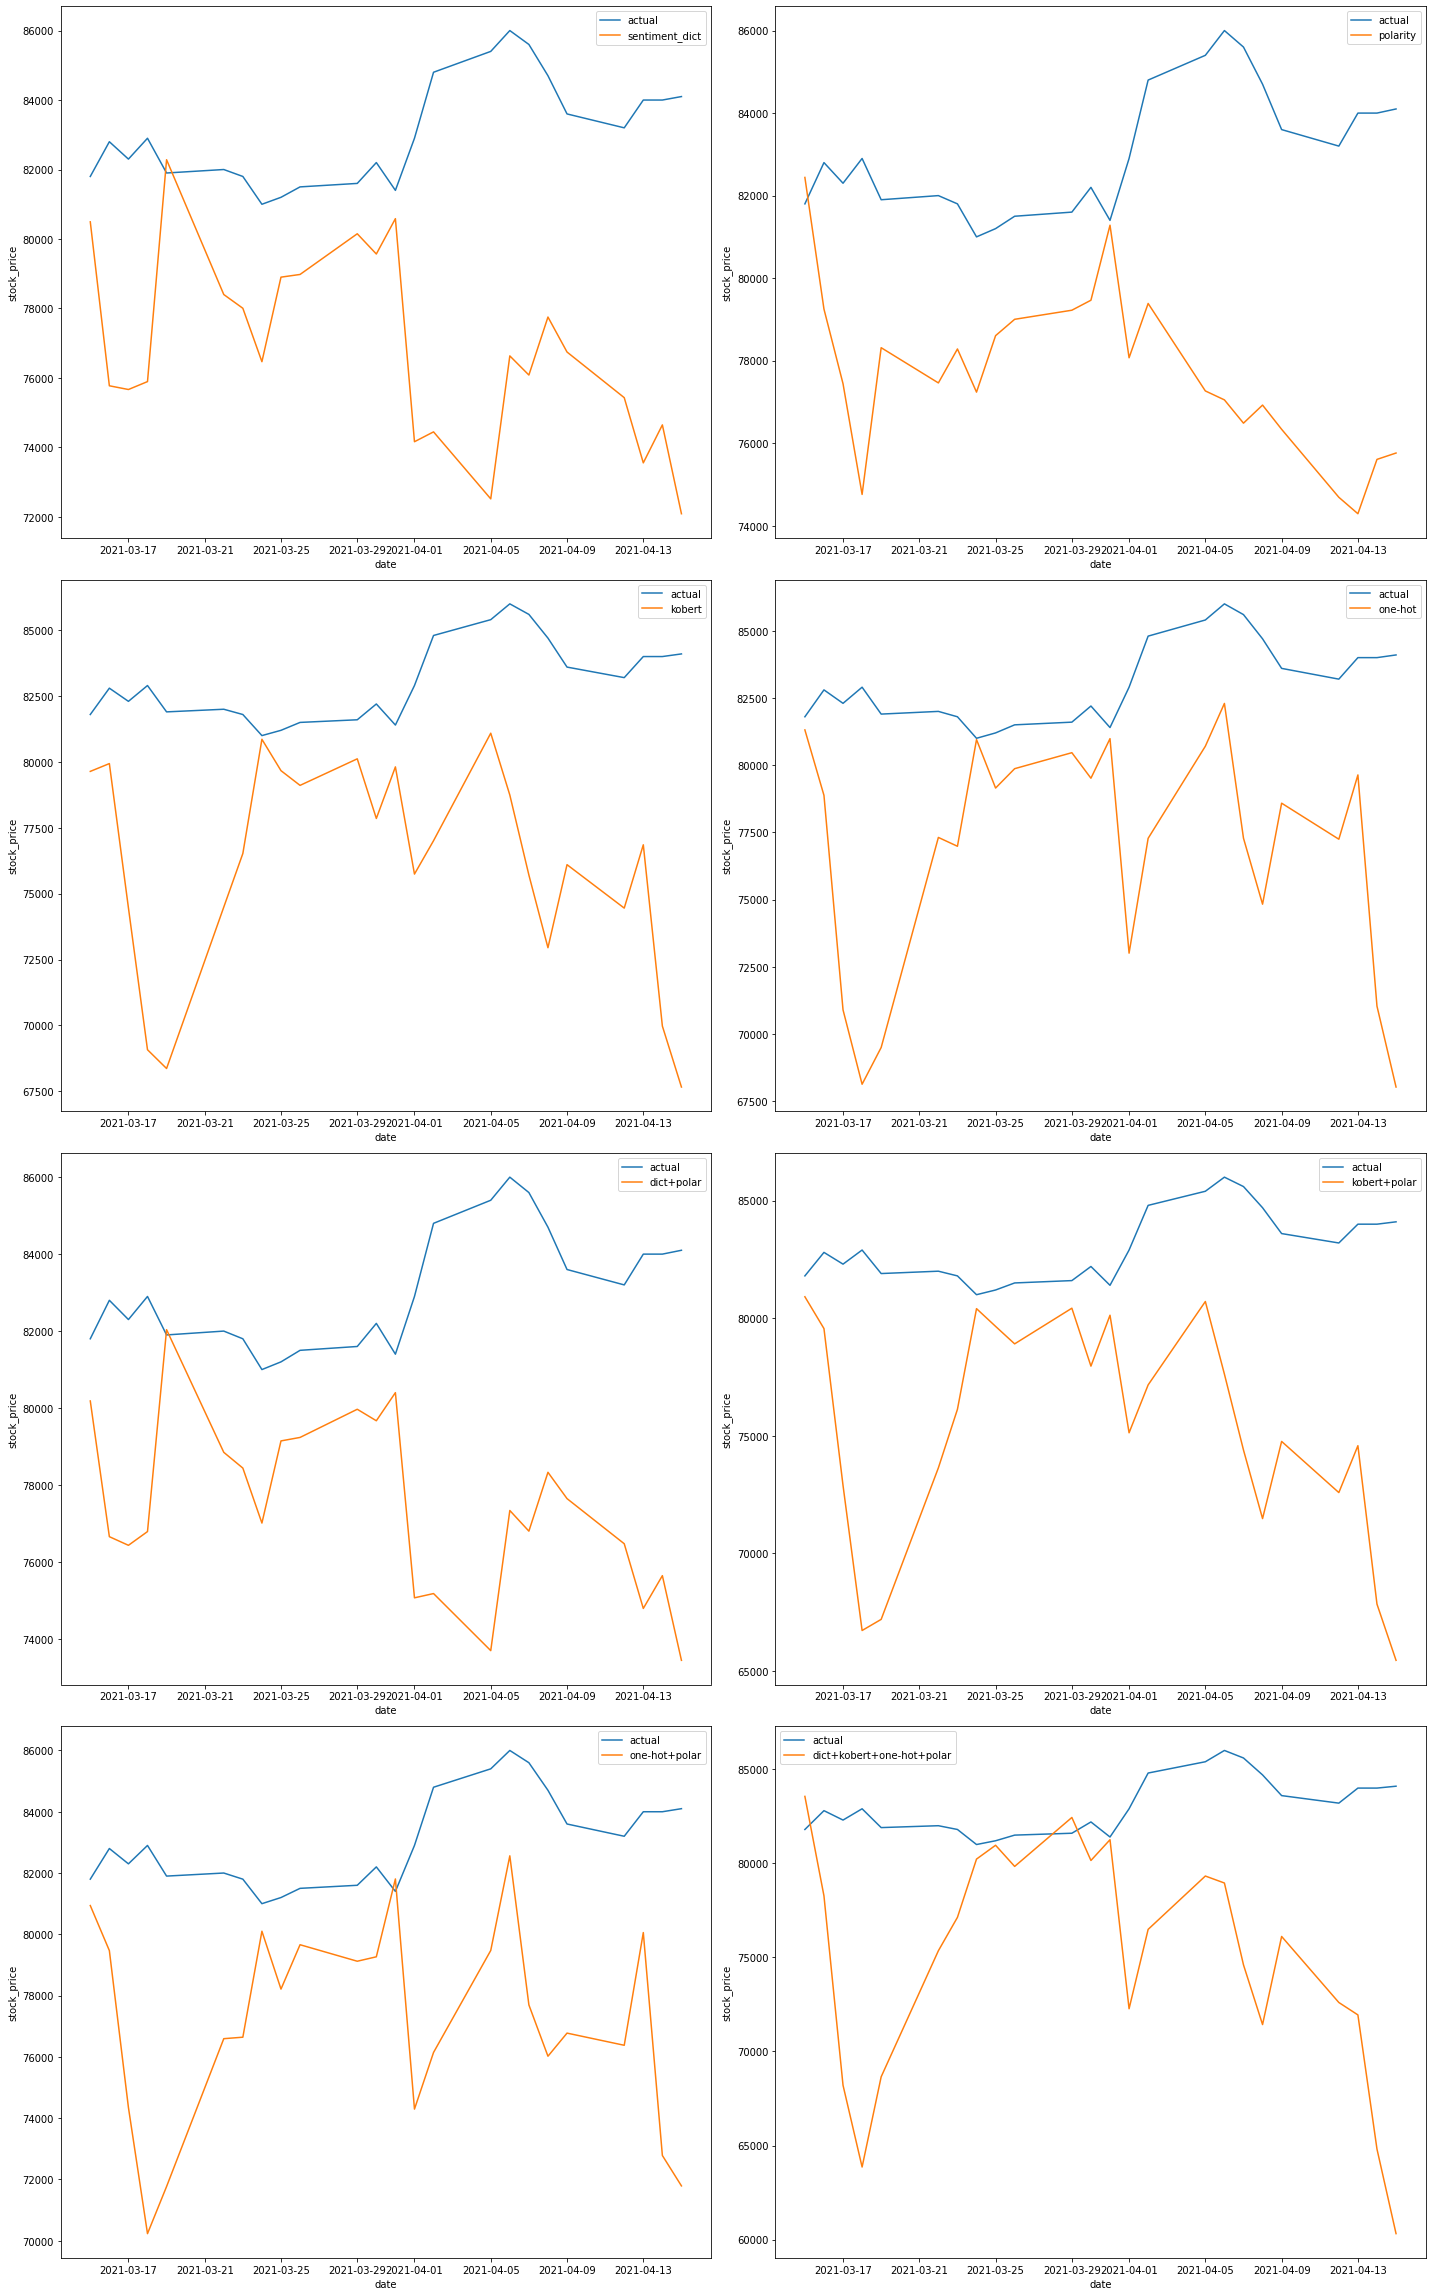

In [270]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]

plt.figure(figsize=(20, 32))
plt.title('Samsung stock prediction')

ax1 = plt.subplot(4,2,1)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_1), label = 'sentiment_dict')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax2 = plt.subplot(4,2,2)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_2), label = 'polarity')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax3 = plt.subplot(4,2,3)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_3), label = 'kobert')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax4 = plt.subplot(4,2,4)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4), label = 'one-hot')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax5 = plt.subplot(4,2,5)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5), label = 'dict+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax6 = plt.subplot(4,2,6)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_6), label = 'kobert+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax7 = plt.subplot(4,2,7)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_7), label = 'one-hot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax8 = plt.subplot(4,2,8)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_8), label = 'dict+kobert+one-hot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()


plt.tight_layout()
plt.show()

In [271]:
result_data_1 = pd.DataFrame(predicted_stock_1)
result_data_2 = pd.DataFrame(predicted_stock_2)
result_data_3 = pd.DataFrame(predicted_stock_3)
result_data_4 = pd.DataFrame(predicted_stock_4)
result_data_5 = pd.DataFrame(predicted_stock_5)
result_data_6 = pd.DataFrame(predicted_stock_6)
result_data_7 = pd.DataFrame(predicted_stock_7)
result_data_8 = pd.DataFrame(predicted_stock_8)

In [272]:
for i in range(50):
    print(f'___________________________________________{i}_______________________________________________')
    model_1.fit(x_train_1, y_train_1, epochs=300, batch_size=16, validation_data=(x_valid_1, y_valid_1), 
                        callbacks=[early_stop])
    predicted_stock_1 = model_1.predict(test_feature_1)
    result_data_1 = pd.concat([result_data_1, pd.DataFrame(predicted_stock_1)], axis=1)

    model_2.fit(x_train_2, y_train_2, epochs=300, batch_size=16, validation_data=(x_valid_2, y_valid_2), 
                        callbacks=[early_stop])
    predicted_stock_2 = model_2.predict(test_feature_2)
    result_data_2 = pd.concat([result_data_2, pd.DataFrame(predicted_stock_2)], axis=1)

    model_3.fit(x_train_3, y_train_3, epochs=300, batch_size=16, validation_data=(x_valid_3, y_valid_3), 
                        callbacks=[early_stop])
    predicted_stock_3 = model_3.predict(test_feature_3)
    result_data_3 = pd.concat([result_data_3, pd.DataFrame(predicted_stock_3)], axis=1)

    model_4.fit(x_train_4, y_train_4, epochs=300, batch_size=16, validation_data=(x_valid_4, y_valid_4), 
                        callbacks=[early_stop])
    predicted_stock_4 = model_4.predict(test_feature_4)
    result_data_4 = pd.concat([result_data_4, pd.DataFrame(predicted_stock_4)], axis=1)

    model_5.fit(x_train_5, y_train_5, epochs=300, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                        callbacks=[early_stop])
    predicted_stock_5 = model_5.predict(test_feature_5)
    result_data_5 = pd.concat([result_data_5, pd.DataFrame(predicted_stock_5)], axis=1)

    model_6.fit(x_train_6, y_train_6, epochs=300, batch_size=16, validation_data=(x_valid_6, y_valid_6), 
                        callbacks=[early_stop])
    predicted_stock_6 = model_6.predict(test_feature_6)
    result_data_6 = pd.concat([result_data_6, pd.DataFrame(predicted_stock_6)], axis=1)

    model_7.fit(x_train_7, y_train_7, epochs=300, batch_size=16, validation_data=(x_valid_7, y_valid_7), 
                        callbacks=[early_stop])
    predicted_stock_7 = model_7.predict(test_feature_7)
    result_data_7 = pd.concat([result_data_7, pd.DataFrame(predicted_stock_7)], axis=1)

    model_8.fit(x_train_8, y_train_8, epochs=300, batch_size=16, validation_data=(x_valid_8, y_valid_8), 
                        callbacks=[early_stop])
    predicted_stock_8 = model_8.predict(test_feature_8)
    result_data_8 = pd.concat([result_data_8, pd.DataFrame(predicted_stock_8)], axis=1)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3/3 [==============================] - 0s 38ms/step - loss: 0.0382 - val_loss: 0.0138
Epoch 57/300
3/3 [==============================] - 0s 34ms/step - loss: 0.0411 - val_loss: 0.0137
Epoch 58/300
3/3 [==============================] - 0s 36ms/step - loss: 0.0417 - val_loss: 0.0139
Epoch 59/300
3/3 [==============================] - 0s 31ms/step - loss: 0.0376 - val_loss: 0.0137
Epoch 60/300
3/3 [==============================] - 0s 31ms/step - loss: 0.0481 - val_loss: 0.0135
Epoch 61/300
3/3 [==============================] - 0s 31ms/step - loss: 0.0373 - val_loss: 0.0135
Epoch 62/300
3/3 [==============================] - 0s 34ms/step - loss: 0.0410 - val_loss: 0.0134
Epoch 63/300
3/3 [==============================] - 0s 34ms/step - loss: 0.0441 - val_loss: 0.0132
Epoch 64/300
3/3 [==============================] - 0s 32ms/step - loss: 0.0442 - val_loss: 0.0133
Epoch 65/300
3/3 [==============================] - 0s 48ms/step - loss: 0.0457 - val_

In [273]:
result_data_1 = result_data_1.mean(axis=1)
result_data_2 = result_data_2.mean(axis=1)
result_data_3 = result_data_3.mean(axis=1)
result_data_4 = result_data_4.mean(axis=1)
result_data_5 = result_data_5.mean(axis=1)
result_data_6 = result_data_6.mean(axis=1)
result_data_7 = result_data_7.mean(axis=1)
result_data_8 = result_data_8.mean(axis=1)

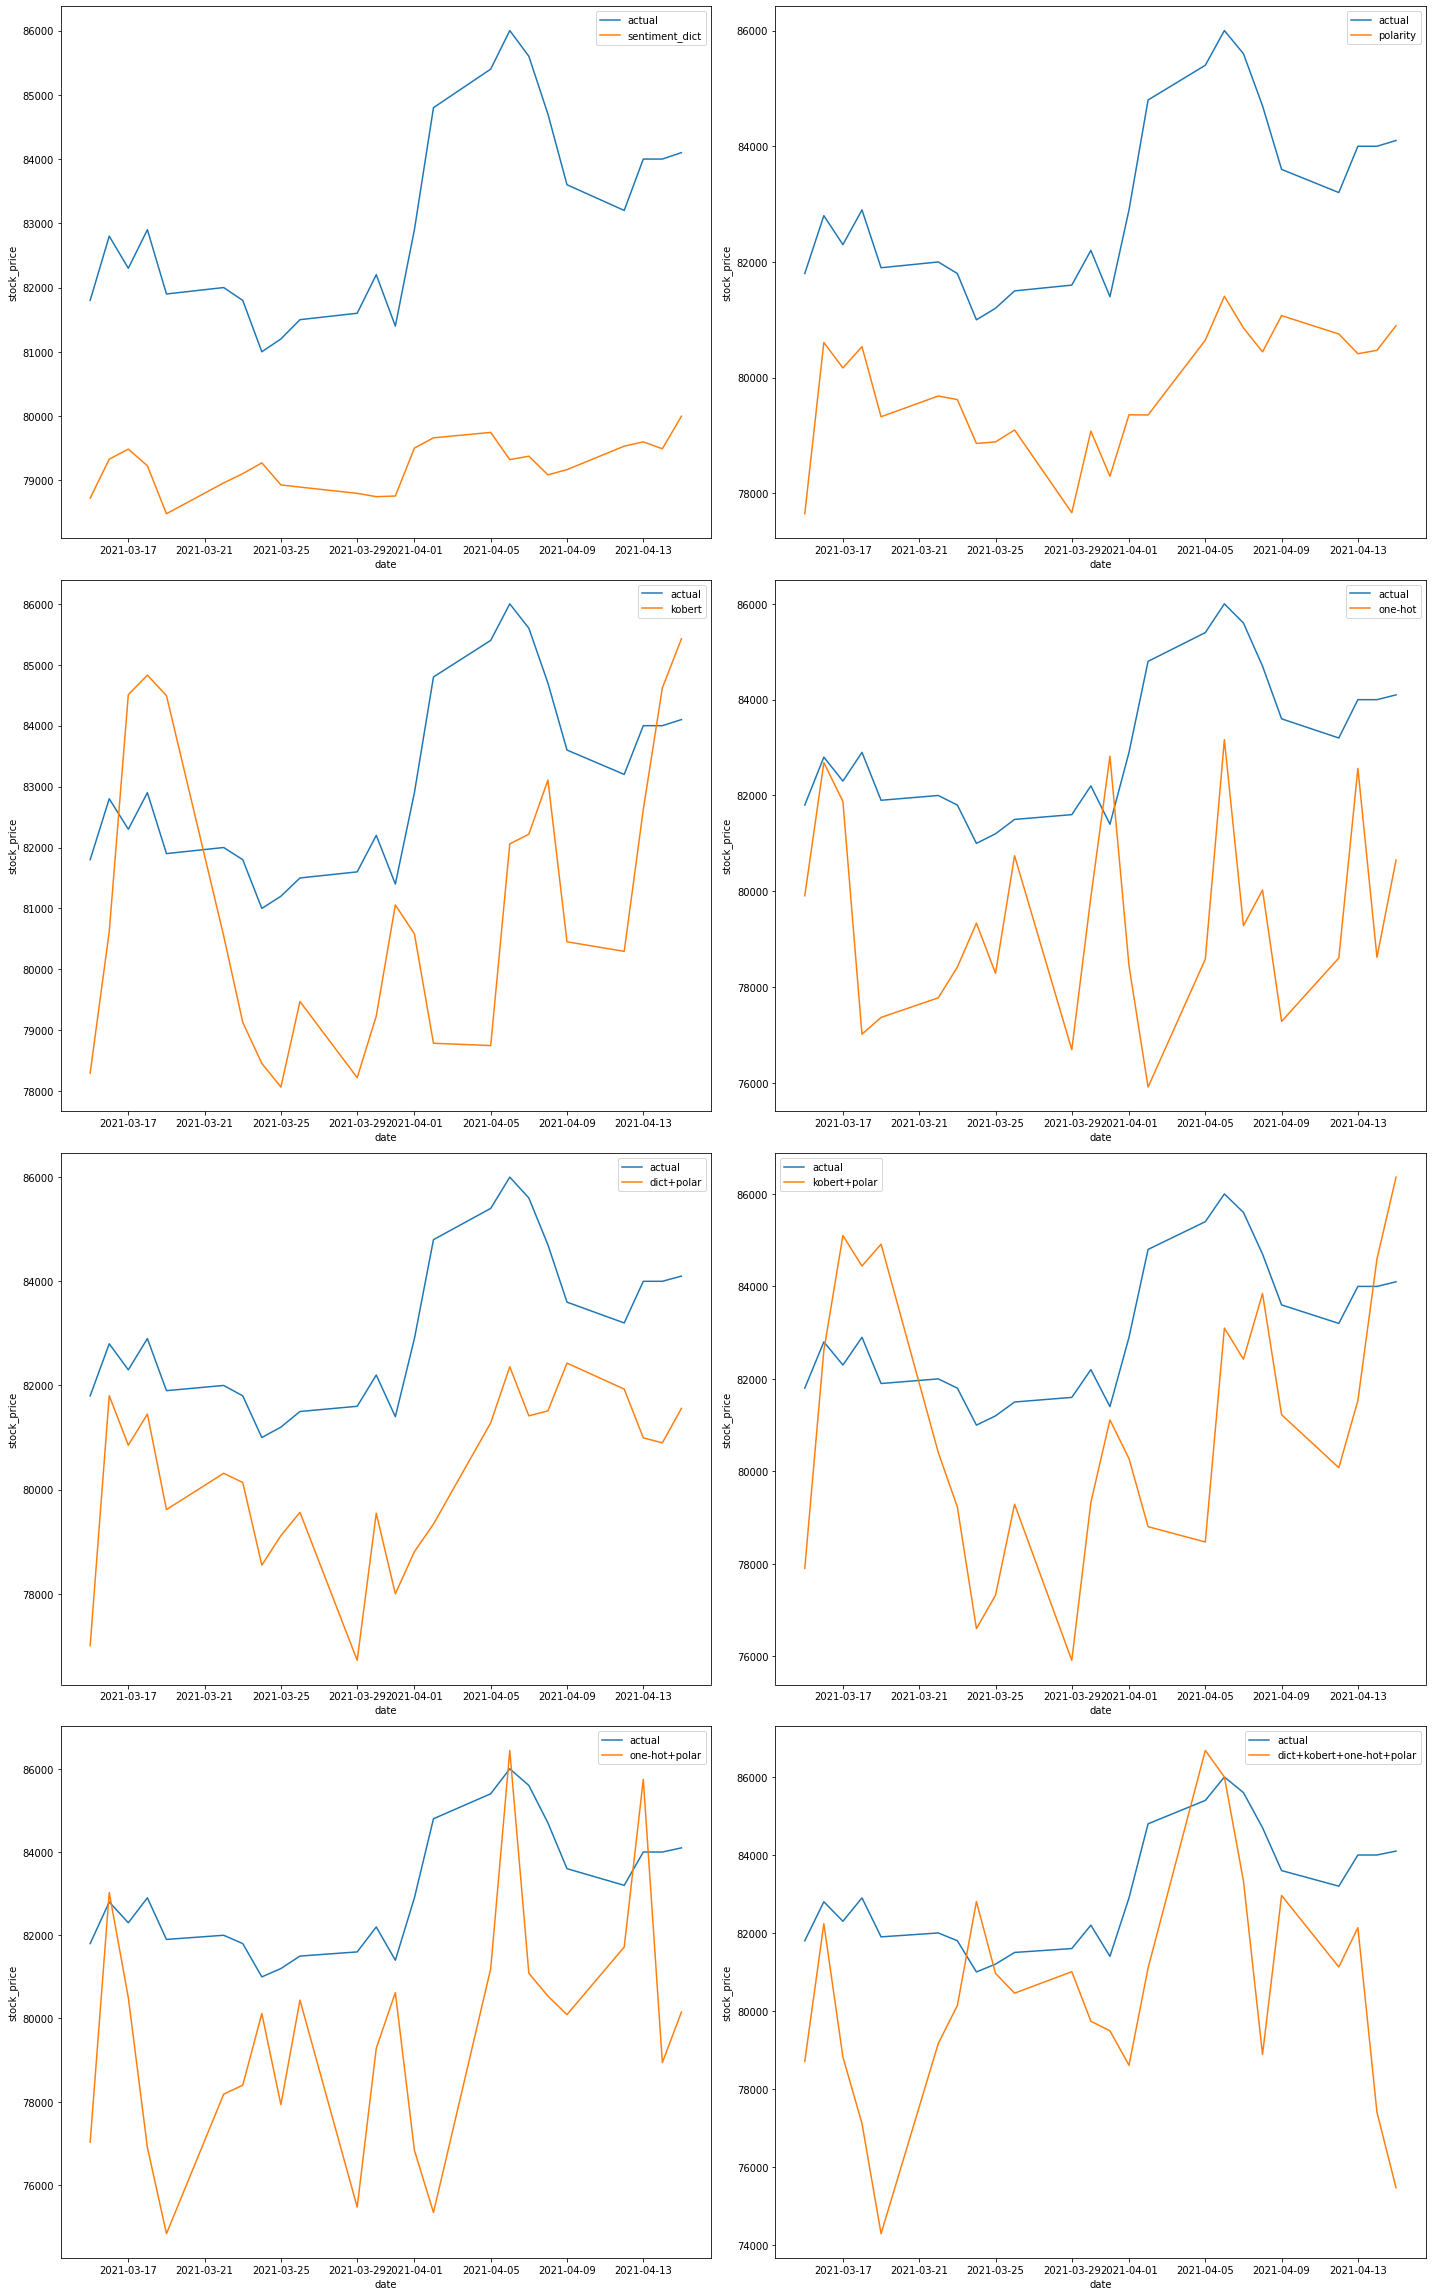

In [274]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]

plt.figure(figsize=(20, 32))
plt.title('Samsung stock prediction')

ax1 = plt.subplot(4,2,1)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_1), label = 'sentiment_dict')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax2 = plt.subplot(4,2,2)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_2), label = 'polarity')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax3 = plt.subplot(4,2,3)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_3), label = 'kobert')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax4 = plt.subplot(4,2,4)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_4), label = 'one-hot')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax5 = plt.subplot(4,2,5)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_5), label = 'dict+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax6 = plt.subplot(4,2,6)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_6), label = 'kobert+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax7 = plt.subplot(4,2,7)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_7), label = 'one-hot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax8 = plt.subplot(4,2,8)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_8), label = 'dict+kobert+one-hot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()


plt.tight_layout()
plt.show()

## LSTM total stock data  / feature (Sentiment)  / label (Change)

In [414]:
samsung_scaled = pd.concat([samsung_stock['Date'], samsung_stock[['Close','Change']]],axis=1)
samsung_scaled = pd.merge(samsung_sentiment, samsung_scaled, how='left', left_on='Date', right_on='Date')
samsung_scaled = samsung_scaled.fillna(0)
for i in range(len(samsung_scaled)):
    if samsung_scaled['Close'].iloc[i] == 0:
        if days[samsung_scaled['Date'].iloc[i].weekday()] == '금':
            samsung_scaled['Date'].iloc[i] = samsung_scaled['Date'].iloc[i] + datetime.timedelta(days=3)
        elif days[samsung_scaled['Date'].iloc[i].weekday()] == '토':
            samsung_scaled['Date'].iloc[i] = samsung_scaled['Date'].iloc[i] + datetime.timedelta(days=2)
        else:
            samsung_scaled['Date'].iloc[i] = samsung_scaled['Date'].iloc[i] + datetime.timedelta(days=1)

samsung_scaled = samsung_scaled.groupby(by='Date').sum()
samsung_scaled['Sentiment Dict'] = samsung_scaled['Sentiment Dict'] / samsung_scaled['counts']
samsung_scaled['Polarity'] = samsung_scaled['Polarity'] / samsung_scaled['counts']
samsung_scaled['Kobert'] = samsung_scaled['Kobert'] / samsung_scaled['counts']
samsung_scaled['One-Hot'] = samsung_scaled['One-Hot'] / samsung_scaled['counts']
samsung_scaled = samsung_scaled.reset_index()
samsung_scaled

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Date,counts,Sentiment Dict,Polarity,Kobert,One-Hot,Close,Change
0,2020-12-22,9,1.000000,0.193950,0.666667,0.666667,72300.0,-0.009589
1,2020-12-23,48,0.791667,0.158841,0.645833,0.500000,73900.0,0.022130
2,2020-12-24,41,0.926829,0.232952,0.682927,0.609756,77800.0,0.052774
3,2020-12-28,83,0.879518,0.136150,0.746988,0.506024,78700.0,0.011568
4,2020-12-29,53,0.735849,0.102068,0.830189,0.547170,78300.0,-0.005083
...,...,...,...,...,...,...,...,...
74,2021-04-09,31,0.741935,0.061577,0.419355,0.354839,83600.0,-0.012987
75,2021-04-12,48,0.666667,0.073916,0.208333,0.312500,83200.0,-0.004785
76,2021-04-13,40,0.550000,0.057471,0.375000,0.350000,84000.0,0.009615
77,2021-04-14,41,0.658537,0.059198,0.268293,0.097561,84000.0,0.000000


In [405]:
# 79일간 samsung data
TEST_SIZE = 27    # 최근 15일간의 주가를 예측하겠다
WINDOW_SIZE = 3   # 5일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = samsung_scaled[:-TEST_SIZE]     
test = samsung_scaled[-TEST_SIZE:]      # 최근 15일간의 데이터 -> test 데이터

In [371]:
feature_cols_1 = ['Sentiment Dict']
feature_cols_2 = ['Polarity']
feature_cols_3 = ['Kobert']
feature_cols_4 = ['One-Hot']
feature_cols_5 = ['Sentiment Dict', 'Polarity']
feature_cols_6 = ['Kobert', 'Polarity']
feature_cols_7 = ['One-Hot', 'Polarity']
feature_cols_8 = ['Sentiment Dict', 'Kobert', 'One-Hot', 'Polarity']

label_cols = ['Change']  # label 데이터(종가)

train_feature_1 = train[feature_cols_1]
train_feature_2 = train[feature_cols_2]
train_feature_3 = train[feature_cols_3]
train_feature_4 = train[feature_cols_4]
train_feature_5 = train[feature_cols_5]
train_feature_6 = train[feature_cols_6]
train_feature_7 = train[feature_cols_7]
train_feature_8 = train[feature_cols_8]

train_label = train[label_cols]

# train dataset 생성
train_feature_1, train_label_1 = make_dataset(train_feature_1, train_label, WINDOW_SIZE)
train_feature_2, train_label_2 = make_dataset(train_feature_2, train_label, WINDOW_SIZE)
train_feature_3, train_label_3 = make_dataset(train_feature_3, train_label, WINDOW_SIZE)
train_feature_4, train_label_4 = make_dataset(train_feature_4, train_label, WINDOW_SIZE)
train_feature_5, train_label_5 = make_dataset(train_feature_5, train_label, WINDOW_SIZE)
train_feature_6, train_label_6 = make_dataset(train_feature_6, train_label, WINDOW_SIZE)
train_feature_7, train_label_7 = make_dataset(train_feature_7, train_label, WINDOW_SIZE)
train_feature_8, train_label_8 = make_dataset(train_feature_8, train_label, WINDOW_SIZE)


# train, validation set 생성
x_train_1, x_valid_1, y_train_1, y_valid_1 = train_test_split(train_feature_1, train_label_1, test_size=0.2)
x_train_2, x_valid_2, y_train_2, y_valid_2 = train_test_split(train_feature_2, train_label_2, test_size=0.2)
x_train_3, x_valid_3, y_train_3, y_valid_3 = train_test_split(train_feature_3, train_label_3, test_size=0.2)
x_train_4, x_valid_4, y_train_4, y_valid_4 = train_test_split(train_feature_4, train_label_4, test_size=0.2)
x_train_5, x_valid_5, y_train_5, y_valid_5 = train_test_split(train_feature_5, train_label_5, test_size=0.2)
x_train_6, x_valid_6, y_train_6, y_valid_6 = train_test_split(train_feature_6, train_label_6, test_size=0.2)
x_train_7, x_valid_7, y_train_7, y_valid_7 = train_test_split(train_feature_7, train_label_7, test_size=0.2)
x_train_8, x_valid_8, y_train_8, y_valid_8 = train_test_split(train_feature_8, train_label_8, test_size=0.2)


# test dataset (실제 예측 해볼 데이터)
test_feature_1 = test[feature_cols_1]
test_feature_2 = test[feature_cols_2]
test_feature_3 = test[feature_cols_3]
test_feature_4 = test[feature_cols_4]
test_feature_5 = test[feature_cols_5]
test_feature_6 = test[feature_cols_6]
test_feature_7 = test[feature_cols_7]
test_feature_8 = test[feature_cols_8]
test_label = test[label_cols]

test_feature_1, test_label_1 = make_dataset(test_feature_1, test_label, WINDOW_SIZE)
test_feature_2, test_label_2 = make_dataset(test_feature_2, test_label, WINDOW_SIZE)
test_feature_3, test_label_3 = make_dataset(test_feature_3, test_label, WINDOW_SIZE)
test_feature_4, test_label_4 = make_dataset(test_feature_4, test_label, WINDOW_SIZE)
test_feature_5, test_label_5 = make_dataset(test_feature_5, test_label, WINDOW_SIZE)
test_feature_6, test_label_6 = make_dataset(test_feature_6, test_label, WINDOW_SIZE)
test_feature_7, test_label_7 = make_dataset(test_feature_7, test_label, WINDOW_SIZE)
test_feature_8, test_label_8 = make_dataset(test_feature_8, test_label, WINDOW_SIZE)

### 모델 1. sentiment dict

In [372]:
# 모델 생성
model_1 = Sequential()
model_1.add(LSTM(32, input_shape=(train_feature_1.shape[1], train_feature_1.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_1.add(Dropout(0.3))
model_1.add(Dense(1))
model_1.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_1 = model_1.fit(x_train_1, y_train_1, epochs=300, batch_size=16, validation_data=(x_valid_1, y_valid_1), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 2s 148ms/step - loss: 0.0023 - val_loss: 3.5269e-04
Epoch 2/300
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - val_loss: 2.5110e-04
Epoch 3/300
3/3 [==============================] - 0s 23ms/step - loss: 0.0021 - val_loss: 2.4174e-04
Epoch 4/300
3/3 [==============================] - 0s 30ms/step - loss: 0.0020 - val_loss: 2.4122e-04
Epoch 5/300
3/3 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 2.5714e-04
Epoch 6/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 3.0529e-04
Epoch 7/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 3.5638e-04
Epoch 8/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0021 - val_loss: 3.8813e-04
Epoch 9/300
3/3 [==============================] - 0s 25ms/step - loss: 9.3261e-04 - val_loss: 3.9145e-04
Epoch 10/300
3/3 [==============================] - 0s 26ms/step - loss: 0.00

In [373]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_1 = model_1.predict(test_feature_1)

In [374]:
model_1.evaluate(test_feature_1, test_label_1) # 0.0024

1/1 [==============================] - 0s 16ms/step - loss: 1.0632e-04


0.00010632345220074058

### 모델 2. polarity

In [375]:
# 모델 생성
model_2 = Sequential()
model_2.add(LSTM(32, input_shape=(train_feature_2.shape[1], train_feature_2.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_2.add(Dropout(0.3))
model_2.add(Dense(1))
model_2.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_2 = model_2.fit(x_train_2, y_train_2, epochs=300, batch_size=16, validation_data=(x_valid_2, y_valid_2), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 2s 157ms/step - loss: 4.6270e-04 - val_loss: 3.4600e-04
Epoch 2/300
3/3 [==============================] - 0s 25ms/step - loss: 4.2715e-04 - val_loss: 3.5456e-04
Epoch 3/300
3/3 [==============================] - 0s 24ms/step - loss: 4.0899e-04 - val_loss: 3.5483e-04
Epoch 4/300
3/3 [==============================] - 0s 26ms/step - loss: 5.6104e-04 - val_loss: 3.5320e-04
Epoch 5/300
3/3 [==============================] - 0s 26ms/step - loss: 4.4577e-04 - val_loss: 3.5523e-04
Epoch 6/300
3/3 [==============================] - 0s 33ms/step - loss: 5.1387e-04 - val_loss: 3.6476e-04
Epoch 7/300
3/3 [==============================] - 0s 26ms/step - loss: 4.5433e-04 - val_loss: 3.7777e-04
Epoch 8/300
3/3 [==============================] - 0s 23ms/step - loss: 5.7951e-04 - val_loss: 3.9068e-04
Epoch 9/300
3/3 [==============================] - 0s 26ms/step - loss: 4.4278e-04 - val_loss: 3.9298e-04
Epoch 10/300
3/3 [===========================

In [376]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_2 = model_2.predict(test_feature_2)

In [377]:
model_2.evaluate(test_feature_2, test_label_2) # / 0.0027 / 0.0030

1/1 [==============================] - 0s 16ms/step - loss: 9.7448e-05


9.744830458657816e-05

### 모델 3. kobert

In [378]:
# 모델 생성
model_3 = Sequential()
model_3.add(LSTM(32, input_shape=(train_feature_3.shape[1], train_feature_3.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_3.add(Dropout(0.3))
model_3.add(Dense(1))
model_3.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_3 = model_3.fit(x_train_3, y_train_3, epochs=300, batch_size=16, validation_data=(x_valid_2, y_valid_2), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 3s 145ms/step - loss: 0.0014 - val_loss: 3.6082e-04
Epoch 2/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0022 - val_loss: 3.7331e-04
Epoch 3/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0016 - val_loss: 3.5024e-04
Epoch 4/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0017 - val_loss: 3.5216e-04
Epoch 5/300
3/3 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 3.7927e-04
Epoch 6/300
3/3 [==============================] - 0s 23ms/step - loss: 0.0017 - val_loss: 4.1336e-04
Epoch 7/300
3/3 [==============================] - 0s 23ms/step - loss: 0.0014 - val_loss: 4.1683e-04
Epoch 8/300
3/3 [==============================] - 0s 23ms/step - loss: 0.0020 - val_loss: 3.8719e-04
Epoch 9/300
3/3 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 3.6711e-04
Epoch 10/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0013 -

In [379]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_3 = model_3.predict(test_feature_3)

In [380]:
model_3.evaluate(test_feature_3, test_label_3) # / 0.0060 / 0.01

1/1 [==============================] - 0s 22ms/step - loss: 9.0602e-05


9.060237789526582e-05

### 모델 4. one-hot

In [381]:
# 모델 생성
model_4 = Sequential()
model_4.add(LSTM(32, input_shape=(train_feature_4.shape[1], train_feature_4.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_4.add(Dropout(0.3))
model_4.add(Dense(1))
model_4.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4 = model_4.fit(x_train_4, y_train_4, epochs=300, batch_size=16, validation_data=(x_valid_4, y_valid_4), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 3s 157ms/step - loss: 0.0016 - val_loss: 5.5938e-04
Epoch 2/300
3/3 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 4.7560e-04
Epoch 3/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0016 - val_loss: 4.1170e-04
Epoch 4/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0017 - val_loss: 3.9622e-04
Epoch 5/300
3/3 [==============================] - 0s 27ms/step - loss: 7.2119e-04 - val_loss: 3.4613e-04
Epoch 6/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0018 - val_loss: 3.1768e-04
Epoch 7/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0012 - val_loss: 3.1488e-04
Epoch 8/300
3/3 [==============================] - 0s 24ms/step - loss: 9.3283e-04 - val_loss: 3.2077e-04
Epoch 9/300
3/3 [==============================] - 0s 26ms/step - loss: 8.8992e-04 - val_loss: 3.1974e-04
Epoch 10/300
3/3 [==============================] - 0s 24ms/step - lo

In [382]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_4 = model_4.predict(test_feature_4)

In [383]:
model_4.evaluate(test_feature_4, test_label_4) # / 0.0037 / 0.0055

1/1 [==============================] - 0s 15ms/step - loss: 1.0612e-04


0.00010611850302666426

### 모델 5. sentiment_dict + polarity

In [384]:
# 모델 생성
model_5 = Sequential()
model_5.add(LSTM(32, input_shape=(train_feature_5.shape[1], train_feature_5.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_5.add(Dropout(0.3))
model_5.add(Dense(1))
model_5.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5 = model_5.fit(x_train_5, y_train_5, epochs=300, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 3s 158ms/step - loss: 0.0026 - val_loss: 3.5955e-04
Epoch 2/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0026 - val_loss: 2.5597e-04
Epoch 3/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0021 - val_loss: 1.9301e-04
Epoch 4/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0027 - val_loss: 1.7737e-04
Epoch 5/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 1.8372e-04
Epoch 6/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0026 - val_loss: 1.7817e-04
Epoch 7/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0013 - val_loss: 1.8197e-04
Epoch 8/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0040 - val_loss: 2.0160e-04
Epoch 9/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0027 - val_loss: 2.2862e-04
Epoch 10/300
3/3 [==============================] - 0s 27ms/step - loss: 0.0017 -

In [385]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_5 = model_5.predict(test_feature_5)

In [386]:
model_5.evaluate(test_feature_5, test_label_5) # / 0.0027 / 0.0031

1/1 [==============================] - 0s 16ms/step - loss: 9.8808e-05


9.880822472041473e-05

### 모델 6. kobert + polarity

In [387]:
# 모델 생성
model_6 = Sequential()
model_6.add(LSTM(32, input_shape=(train_feature_6.shape[1], train_feature_6.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_6.add(Dropout(0.3))
model_6.add(Dense(1))
model_6.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_6 = model_6.fit(x_train_6, y_train_6, epochs=300, batch_size=16, validation_data=(x_valid_6, y_valid_6), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 2s 165ms/step - loss: 0.0145 - val_loss: 0.0092
Epoch 2/300
3/3 [==============================] - 0s 23ms/step - loss: 0.0089 - val_loss: 0.0060
Epoch 3/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0067 - val_loss: 0.0038
Epoch 4/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 5/300
3/3 [==============================] - 0s 31ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 6/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0025 - val_loss: 9.5292e-04
Epoch 7/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0014 - val_loss: 7.1522e-04
Epoch 8/300
3/3 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 6.1814e-04
Epoch 9/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0012 - val_loss: 6.0449e-04
Epoch 10/300
3/3 [==============================] - 0s 27ms/step - loss: 0.0014 - val_loss: 6.2319e-0

In [388]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_6 = model_6.predict(test_feature_6)

In [389]:
model_6.evaluate(test_feature_6, test_label_6) # / 0.0059 / 0.0082

1/1 [==============================] - 0s 17ms/step - loss: 1.8560e-04


0.00018559535965323448

### 모델 7. one-hot + polarity

In [390]:
# 모델 생성
model_7 = Sequential()
model_7.add(LSTM(32, input_shape=(train_feature_7.shape[1], train_feature_7.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_7.add(Dropout(0.3))
model_7.add(Dense(1))
model_7.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_7 = model_7.fit(x_train_7, y_train_7, epochs=300, batch_size=16, validation_data=(x_valid_7, y_valid_7), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 2s 152ms/step - loss: 0.0034 - val_loss: 4.5459e-04
Epoch 2/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0019 - val_loss: 2.1831e-04
Epoch 3/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0021 - val_loss: 2.2685e-04
Epoch 4/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0019 - val_loss: 2.7154e-04
Epoch 5/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0016 - val_loss: 2.4613e-04
Epoch 6/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0022 - val_loss: 2.1245e-04
Epoch 7/300
3/3 [==============================] - 0s 27ms/step - loss: 0.0015 - val_loss: 2.0217e-04
Epoch 8/300
3/3 [==============================] - 0s 29ms/step - loss: 0.0020 - val_loss: 2.3698e-04
Epoch 9/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0027 - val_loss: 2.9439e-04
Epoch 10/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0016 -

In [391]:
# 특성 5가지를 가지고 예측한 주가 12일치 = (test_size - window_size)
predicted_stock_7 = model_7.predict(test_feature_7)

In [392]:
model_7.evaluate(test_feature_7, test_label_7) # / 0.0039 / 0.0076

1/1 [==============================] - 0s 16ms/step - loss: 1.1726e-04


0.00011725920921890065

### 모델 8. 'Sentiment Dict', 'Kobert', 'One-Hot', 'Polarity'

In [393]:
# 모델 생성
model_8 = Sequential()
model_8.add(LSTM(32, input_shape=(train_feature_8.shape[1], train_feature_8.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_8.add(Dropout(0.3))
model_8.add(Dense(1))
model_8.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=50)  # 50번 연속 개선이 없으면 조기종료

# best 모델 저장
#checkpoint = ModelCheckpoint('samsung_model_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_8 = model_8.fit(x_train_8, y_train_8, epochs=300, batch_size=16, validation_data=(x_valid_8, y_valid_8), 
                        callbacks=[early_stop])
                    #callbacks=[early_stop, checkpoint])

Epoch 1/300
3/3 [==============================] - 2s 160ms/step - loss: 0.0076 - val_loss: 3.0883e-04
Epoch 2/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0074 - val_loss: 5.5642e-04
Epoch 3/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 4/300
3/3 [==============================] - 0s 28ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 5/300
3/3 [==============================] - 0s 28ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 6/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0035 - val_loss: 8.5407e-04
Epoch 7/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0035 - val_loss: 5.5638e-04
Epoch 8/300
3/3 [==============================] - 0s 30ms/step - loss: 0.0071 - val_loss: 4.0948e-04
Epoch 9/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0049 - val_loss: 3.6581e-04
Epoch 10/300
3/3 [==============================] - 0s 27ms/step - loss: 0.0035 - val_loss: 3

In [394]:
predicted_stock_8 = model_8.predict(test_feature_8)
model_8.evaluate(test_feature_8, test_label_8) # 0.0050

1/1 [==============================] - 0s 18ms/step - loss: 1.6030e-04


0.00016030123515520245

In [421]:
def change_to_price(stock_price, change): 
    stock_price_np = np.asarray(stock_price)
    stock_price_np = np.delete(np.asarray(stock_price_np), -1)
    #np.insert(stock_price_np, 0, stock_price_np[0])
    change_np = np.asarray(change).reshape(-1,)
    return change_np * stock_price_np + stock_price_np

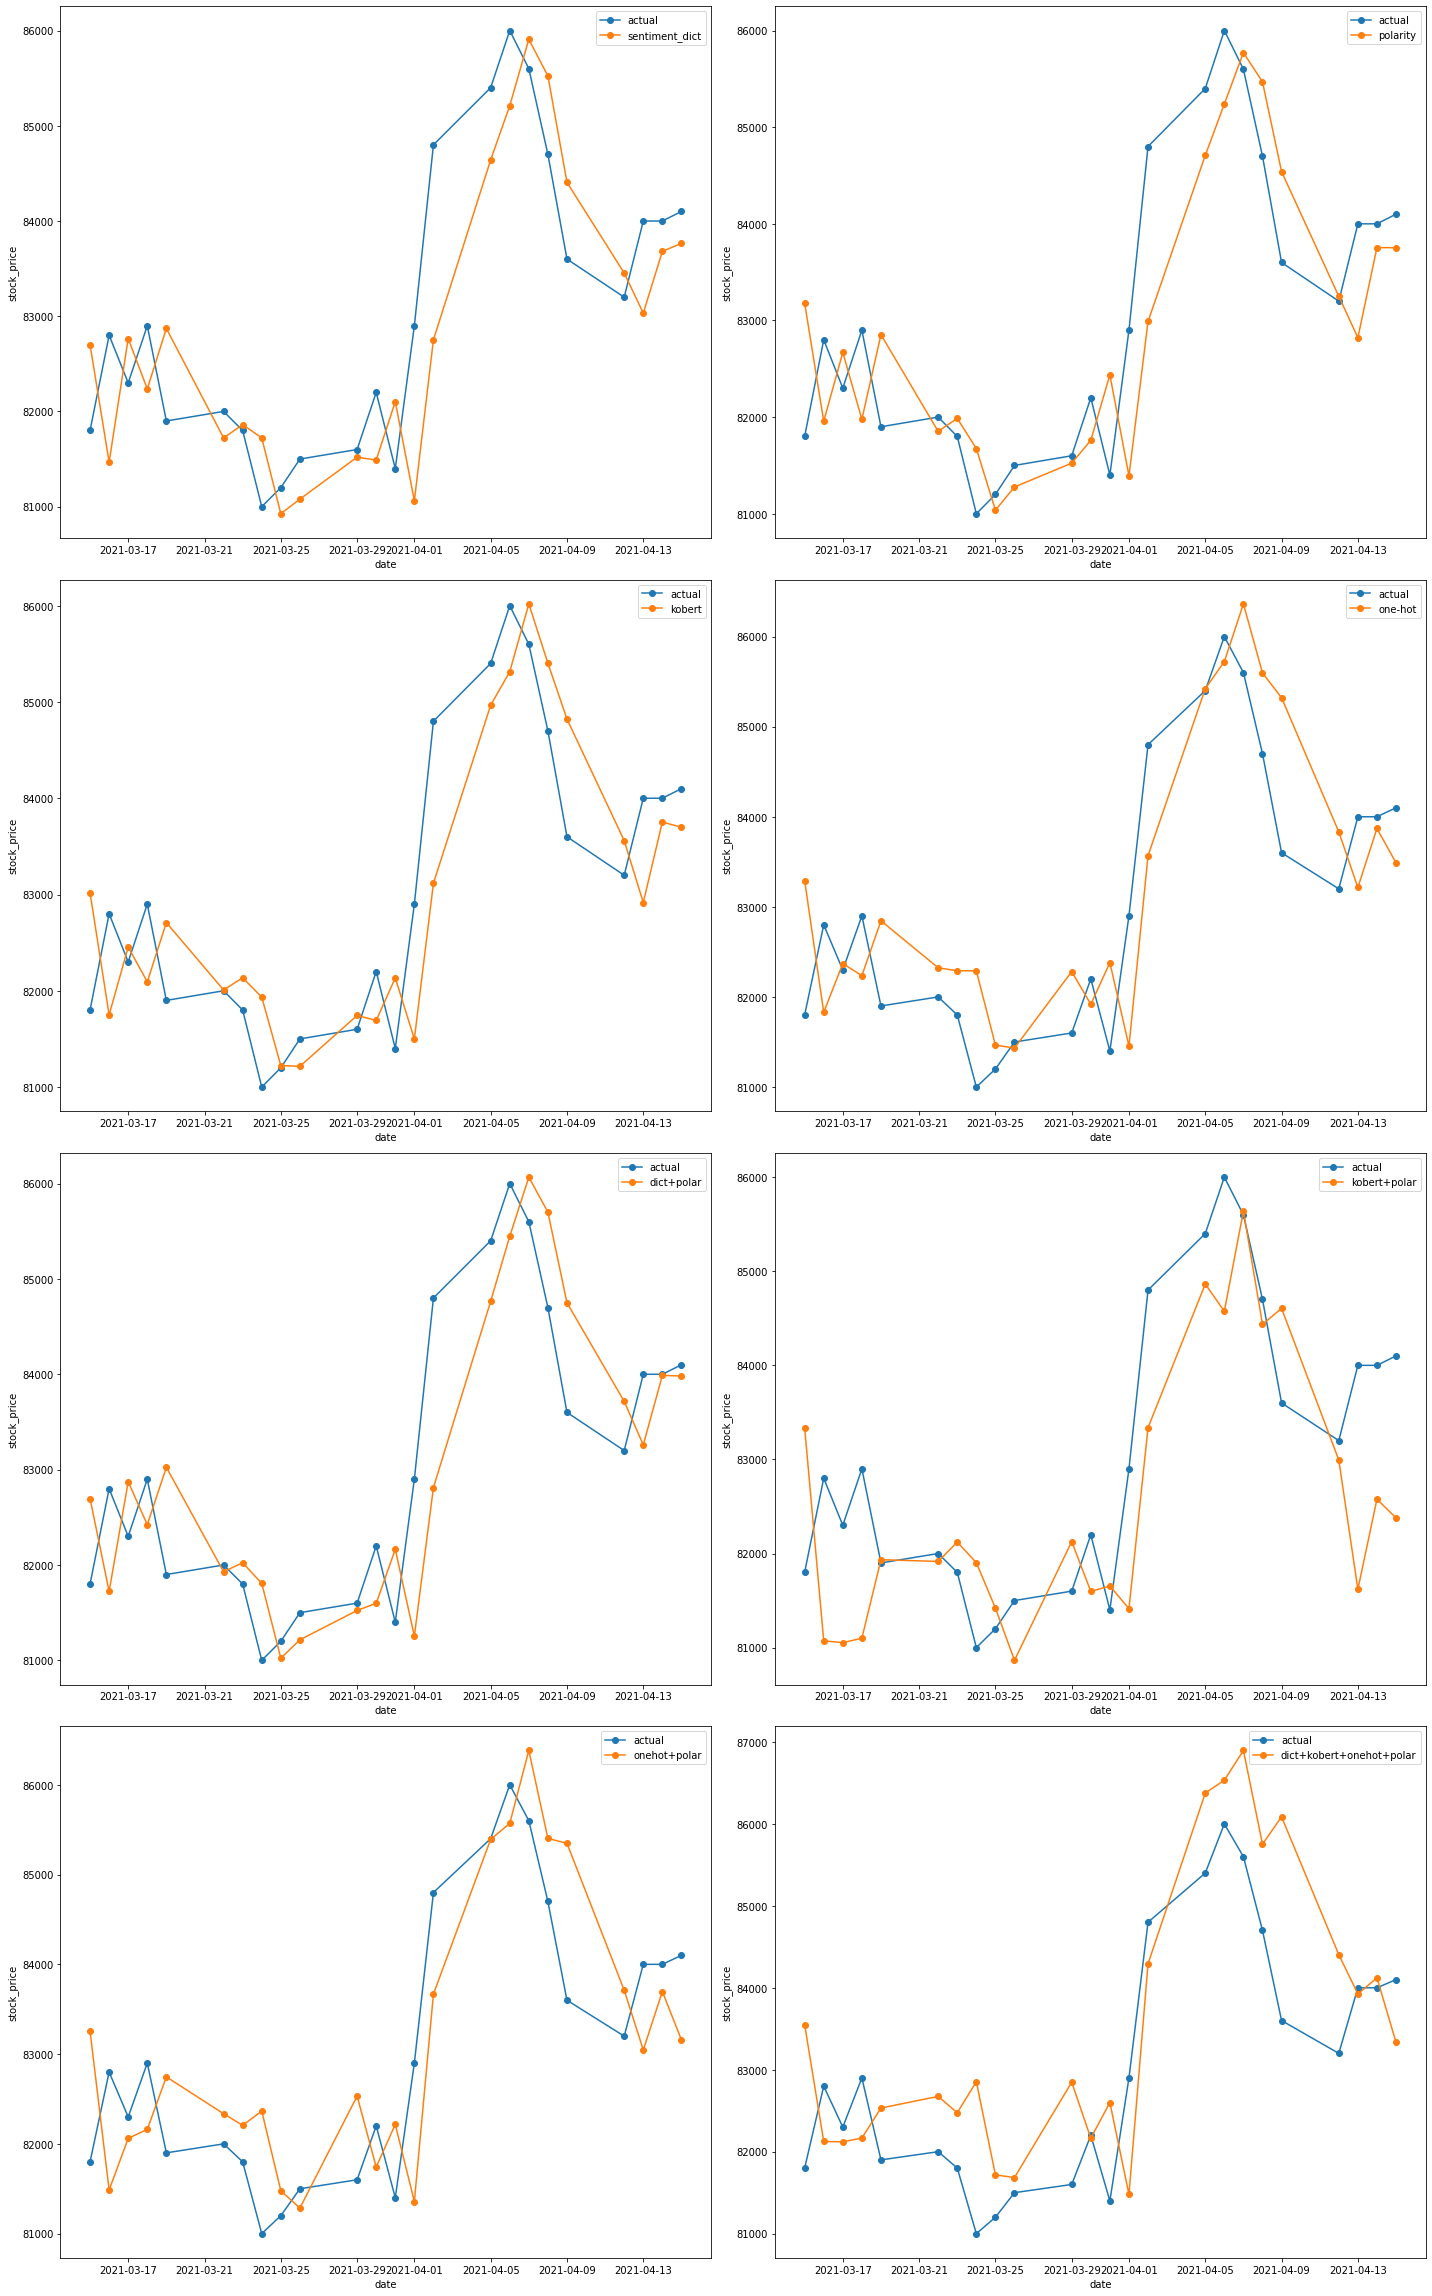

In [430]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]

plt.figure(figsize=(20, 32))
plt.title('Samsung stock prediction')

ax1 = plt.subplot(4,2,1)
graph1 = plt.plot(time_list, samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE):], 'o-', label = 'actual')
graph2 = plt.plot(time_list, change_to_price(samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE+1):], predicted_stock_1), 'o-', label = 'sentiment_dict')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax2 = plt.subplot(4,2,2)
graph1 = plt.plot(time_list, samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE):], 'o-', label = 'actual')
graph2 = plt.plot(time_list, change_to_price(samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE+1):], predicted_stock_2),'o-', label = 'polarity')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax3 = plt.subplot(4,2,3)
graph1 = plt.plot(time_list, samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE):], 'o-', label = 'actual')
graph2 = plt.plot(time_list, change_to_price(samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE+1):], predicted_stock_3),'o-', label = 'kobert')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax4 = plt.subplot(4,2,4)
graph1 = plt.plot(time_list, samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE):], 'o-', label = 'actual')
graph2 = plt.plot(time_list, change_to_price(samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE+1):], predicted_stock_4),'o-', label = 'one-hot')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax5 = plt.subplot(4,2,5)
graph1 = plt.plot(time_list, samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE):], 'o-', label = 'actual')
graph2 = plt.plot(time_list, change_to_price(samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE+1):], predicted_stock_5),'o-', label = 'dict+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax6 = plt.subplot(4,2,6)
graph1 = plt.plot(time_list, samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE):], 'o-', label = 'actual')
graph2 = plt.plot(time_list, change_to_price(samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE+1):], predicted_stock_6),'o-', label = 'kobert+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax7 = plt.subplot(4,2,7)
graph1 = plt.plot(time_list, samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE):], 'o-', label = 'actual')
graph2 = plt.plot(time_list, change_to_price(samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE+1):], predicted_stock_7),'o-', label = 'onehot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax8 = plt.subplot(4,2,8)
graph1 = plt.plot(time_list, samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE):], 'o-', label = 'actual')
graph2 = plt.plot(time_list, change_to_price(samsung_scaled['Close'][-(TEST_SIZE-WINDOW_SIZE+1):], predicted_stock_8),'o-', label = 'dict+kobert+onehot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')       
plt.legend()

plt.tight_layout()
plt.show()

In [397]:
result_data_1 = pd.DataFrame(predicted_stock_1)
result_data_2 = pd.DataFrame(predicted_stock_2)
result_data_3 = pd.DataFrame(predicted_stock_3)
result_data_4 = pd.DataFrame(predicted_stock_4)
result_data_5 = pd.DataFrame(predicted_stock_5)
result_data_6 = pd.DataFrame(predicted_stock_6)
result_data_7 = pd.DataFrame(predicted_stock_7)
result_data_8 = pd.DataFrame(predicted_stock_8)

In [ ]:
for i in range(10):
    print(f'___________________________________________{i}_______________________________________________')
    model_1.fit(x_train_1, y_train_1, epochs=300, batch_size=16, validation_data=(x_valid_1, y_valid_1), 
                        callbacks=[early_stop])
    predicted_stock_1 = model_1.predict(test_feature_1)
    result_data_1 = pd.concat([result_data_1, pd.DataFrame(predicted_stock_1)], axis=1)

    model_2.fit(x_train_2, y_train_2, epochs=300, batch_size=16, validation_data=(x_valid_2, y_valid_2), 
                        callbacks=[early_stop])
    predicted_stock_2 = model_2.predict(test_feature_2)
    result_data_2 = pd.concat([result_data_2, pd.DataFrame(predicted_stock_2)], axis=1)

    model_3.fit(x_train_3, y_train_3, epochs=300, batch_size=16, validation_data=(x_valid_3, y_valid_3), 
                        callbacks=[early_stop])
    predicted_stock_3 = model_3.predict(test_feature_3)
    result_data_3 = pd.concat([result_data_3, pd.DataFrame(predicted_stock_3)], axis=1)

    model_4.fit(x_train_4, y_train_4, epochs=300, batch_size=16, validation_data=(x_valid_4, y_valid_4), 
                        callbacks=[early_stop])
    predicted_stock_4 = model_4.predict(test_feature_4)
    result_data_4 = pd.concat([result_data_4, pd.DataFrame(predicted_stock_4)], axis=1)

    model_5.fit(x_train_5, y_train_5, epochs=300, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                        callbacks=[early_stop])
    predicted_stock_5 = model_5.predict(test_feature_5)
    result_data_5 = pd.concat([result_data_5, pd.DataFrame(predicted_stock_5)], axis=1)

    model_6.fit(x_train_6, y_train_6, epochs=300, batch_size=16, validation_data=(x_valid_6, y_valid_6), 
                        callbacks=[early_stop])
    predicted_stock_6 = model_6.predict(test_feature_6)
    result_data_6 = pd.concat([result_data_6, pd.DataFrame(predicted_stock_6)], axis=1)

    model_7.fit(x_train_7, y_train_7, epochs=300, batch_size=16, validation_data=(x_valid_7, y_valid_7), 
                        callbacks=[early_stop])
    predicted_stock_7 = model_7.predict(test_feature_7)
    result_data_7 = pd.concat([result_data_7, pd.DataFrame(predicted_stock_7)], axis=1)

    model_8.fit(x_train_8, y_train_8, epochs=300, batch_size=16, validation_data=(x_valid_8, y_valid_8), 
                        callbacks=[early_stop])
    predicted_stock_8 = model_8.predict(test_feature_8)
    result_data_8 = pd.concat([result_data_8, pd.DataFrame(predicted_stock_8)], axis=1)

In [ ]:
result_data_1 = result_data_1.mean(axis=1)
result_data_2 = result_data_2.mean(axis=1)
result_data_3 = result_data_3.mean(axis=1)
result_data_4 = result_data_4.mean(axis=1)
result_data_5 = result_data_5.mean(axis=1)
result_data_6 = result_data_6.mean(axis=1)
result_data_7 = result_data_7.mean(axis=1)
result_data_8 = result_data_8.mean(axis=1)

In [ ]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]

plt.figure(figsize=(20, 32))
plt.title('Samsung stock prediction')

ax1 = plt.subplot(4,2,1)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_1), label = 'sentiment_dict')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax2 = plt.subplot(4,2,2)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_2), label = 'polarity')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax3 = plt.subplot(4,2,3)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_3), label = 'kobert')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax4 = plt.subplot(4,2,4)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_4), label = 'one-hot')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax5 = plt.subplot(4,2,5)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_5), label = 'dict+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax6 = plt.subplot(4,2,6)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_6), label = 'kobert+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax7 = plt.subplot(4,2,7)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_7), label = 'one-hot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()

ax8 = plt.subplot(4,2,8)
graph1 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_1), label = 'actual')
graph2 = plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], result_data_8), label = 'dict+kobert+one-hot+polar')
plt.xlabel('date')
plt.ylabel('stock_price')
plt.legend()


plt.tight_layout()
plt.show()